In [37]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/LJMU_Data_XAI/data/aws-jupyter-notebooks/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
"""
Machine Learning Model Configuration and Augmentation Pipeline

This script contains configurations for multiple ML models, feature engineering parameters,
training and drift detection settings, augmentation strategies, and file path definitions.

It also includes functions for dataset augmentation, auto-detection of text and label columns,
class balancing, and preparation of enhanced datasets for training/testing splits.

Author: [Your Name]
Date: 2025-10-11
"""

import yaml

# Configuration dictionary for ML models, feature engineering, training, drift detection,
# augmentation, drift resistance techniques, and file paths
config = {
    'models': {
        'logistic_regression': {
            'multi_class': 'multinomial',
            'solver': 'lbfgs',
            'max_iter': 1000,
            'random_state': 42,
            'class_weight': 'balanced',
            'C': 0.5,
            'penalty': 'l2'
        },
        'random_forest': {
            'n_estimators': 100,
            'max_depth': 15,
            'random_state': 42,
            'class_weight': 'balanced',
            'min_samples_split': 5,
            'min_samples_leaf': 2
        },
        'decision_tree': {
            'max_depth': 8,
            'random_state': 42,
            'class_weight': 'balanced',
            'min_samples_split': 5,
            'min_samples_leaf': 2
        },
        'neural_network': {
            'hidden_layer_sizes': [50, 25],
            'max_iter': 1000,
            'random_state': 42,
            'early_stopping': True,
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001,
            'alpha': 0.01,
            'activation': 'relu'
        },
        'svm': {
            'kernel': 'linear',
            'probability': True,
            'random_state': 42,
            'class_weight': 'balanced',
            'C': 0.5,
            'gamma': 'scale',
            'decision_function_shape': 'ovr'
        }
    },
    'feature_engineering': {
        'tfidf': {
            'max_features': 800,
            'stop_words': 'english',
            'ngram_range': [1, 2],
            'min_df': 2,
            'max_df': 0.8
        }
    },
    'training': {
        'num_chunks': 8,
        'random_state': 42,
        'primary_metric': 'f1_score',
        'test_size': 0.2,
        'cross_validation_folds': 3
    },
    'drift_detection': {
        'data_drift_threshold': 0.01,
        'concept_drift_threshold': 0.006,
        'significance_level': 0.006
    },
    'augmentation': {
        'text_augmentation_ratio': 0.3,
        'synonym_replacement_ratio': 0.2,
        'back_translation_ratio': 0.1,
        'max_augmented_samples': 100,
        'class_balancing': True
    },
    'drift_resistance': {
        'ensemble_weighting': True,
        'feature_importance_filtering': True,
        'regularization_boost': True,
        'stability_weight': 0.1
    },
    'paths': {
        'original_data': 'balanced_dataset/balanced_dataset.csv',
        'batch_dir': 'batchy-streamy',
        'chunks_dir': 'chunks',
        'models_dir': 'models',
        'best_models_dir': 'best_models',
        'reports_dir': 'reports',
        'drift_reports_dir': 'drift_reports',
        'drift_file': 'test_data_drift_report.pkl',
        'overall_best_model': 'overall_best_model.pkl'
    }
}

# Write configuration to a YAML file for external use
with open('ci-config.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("Created ci-config.yaml")


Created ci-config.yaml


In [39]:
# fixed_data_augmentation.py
import pandas as pd
import numpy as np
import pickle
import os
import random
from datetime import datetime
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

class DataAugmentationPipeline:
    """
    Data augmentation pipeline class for performing various text augmentation techniques,
    managing dataset splits, and batch directory structures.

    Attributes:
        config (dict): Configuration parameters loaded from YAML or defaults.
        batch_dir (str): Directory to store batch data.
        current_batch (int): Number for the current batch (auto-incremented).
    """

    def __init__(self, config_path="ci-config.yaml"):
        """
        Initialize pipeline: load config, set batch directory and batch number.

        Args:
            config_path (str): Path to YAML configuration file.
        """
        self.config = self.load_config(config_path)
        self.batch_dir = "batchy-streamy"
        self.current_batch = 1

    def load_config(self, config_path):
        """
        Load configuration from YAML file with error handling.

        Args:
            config_path (str): Path to config file.

        Returns:
            dict: Loaded config dictionary or default config on failure.
        """
        try:
            import yaml
            if os.path.exists(config_path):
                with open(config_path, 'r') as file:
                    config = yaml.safe_load(file)
                print(f"Configuration loaded from {config_path}")
                return config
            else:
                print(f"Config file {config_path} not found, using defaults")
                return self.get_default_config()
        except Exception as e:
            print(f"Error loading config: {e}, using defaults")
            return self.get_default_config()

    def get_default_config(self):
        """
        Provide a robust default configuration if no config file is found.

        Returns:
            dict: Default configuration dictionary.
        """
        return {
            'augmentation': {
                'text_augmentation_ratio': 0.3,
                'synonym_replacement_ratio': 0.2,
                'back_translation_ratio': 0.1,
                'max_augmented_samples': 100,
                'class_balancing': True
            },
            'paths': {
                'original_data': 'balanced_dataset/balanced_dataset.csv',
                'batch_dir': 'batchy-streamy'
            }
        }

    def find_original_data(self):
        """
        Locate the original data file through a series of fallbacks.

        Returns:
            str or None: Path to original data file if found, else None.
        """
        possible_paths = [
            self.config['paths'].get('original_data', 'balanced_dataset/balanced_dataset.csv'),
            'balanced_dataset/balanced_dataset.csv',
            'balanced_dataset.csv',
            '../balanced_dataset/balanced_dataset.csv',
            'train_test_data/train_data.csv',
            'balanced_dataset.csv'
        ]
        for data_path in possible_paths:
            if os.path.exists(data_path):
                print(f"Found data at: {data_path}")
                return data_path

        print("No data file found. Available files and directories:")
        for item in os.listdir('.'):
            if os.path.isfile(item) and (item.endswith('.csv') or item.endswith('.pkl')):
                print(f"File: {item}")
        for item in os.listdir('.'):
            if os.path.isdir(item):
                print(f"Dir: {item}/")
                try:
                    for subitem in os.listdir(item):
                        if subitem.endswith('.csv') or subitem.endswith('.pkl'):
                            print(f"  File: {subitem}")
                except Exception:
                    pass
        return None

    def load_original_data(self):
        """
        Load the original dataset from the located file path.

        Returns:
            pandas.DataFrame or None: Loaded dataframe or None if failed.
        """
        data_path = self.find_original_data()
        if not data_path:
            return None
        try:
            if data_path.endswith('.pkl'):
                with open(data_path, 'rb') as f:
                    original_df = pickle.load(f)
            else:
                original_df = pd.read_csv(data_path)
            print(f"Loaded data: {original_df.shape}")
            print(f"Columns: {original_df.columns.tolist()}")
            return original_df
        except Exception as e:
            print(f"Error loading data from {data_path}: {e}")
            return None

    def setup_batch_structure(self):
        """
        Create directory structure for current batch including models, reports, and data.

        Returns:
            str: Path to the created batch directory.
        """
        os.makedirs(self.batch_dir, exist_ok=True)

        existing_batches = [d for d in os.listdir(self.batch_dir) if d.startswith('batch_') and os.path.isdir(os.path.join(self.batch_dir, d))]
        if existing_batches:
            batch_numbers = []
            for b in existing_batches:
                try:
                    batch_num = int(b.split('_')[1])
                    batch_numbers.append(batch_num)
                except Exception:
                    continue
            if batch_numbers:
                self.current_batch = max(batch_numbers) + 1
            else:
                self.current_batch = 1
        else:
            self.current_batch = 1

        batch_path = os.path.join(self.batch_dir, f"batch_{self.current_batch}")
        os.makedirs(batch_path, exist_ok=True)
        os.makedirs(os.path.join(batch_path, "models"), exist_ok=True)
        os.makedirs(os.path.join(batch_path, "reports"), exist_ok=True)
        os.makedirs(os.path.join(batch_path, "data"), exist_ok=True)

        print(f"Created batch structure: {batch_path}")
        return batch_path

    def text_augmentation_synonyms(self, text):
        """
        Perform simple synonym replacement for text augmentation.

        Args:
            text (str): Input text to augment.

        Returns:
            str: Augmented text with potential synonyms replaced.
        """
        if not isinstance(text, str) or len(text.strip()) == 0:
            return text

        synonyms = {
            'company': ['business', 'firm', 'corporation', 'enterprise'],
            'industry': ['sector', 'field', 'domain', 'business area'],
            'technology': ['tech', 'innovation', 'digital', 'IT'],
            'financial': ['monetary', 'economic', 'fiscal'],
            'services': ['offerings', 'solutions', 'assistance'],
            'products': ['goods', 'offerings', 'merchandise'],
            'customer': ['client', 'consumer', 'buyer'],
            'market': ['industry', 'sector', 'landscape'],
            'development': ['creation', 'establishment', 'formation'],
            'management': ['administration', 'leadership', 'supervision'],
            'system': ['platform', 'framework', 'infrastructure'],
            'solution': ['approach', 'method', 'technique'],
            'provide': ['offer', 'deliver', 'supply'],
            'help': ['assist', 'support', 'aid'],
            'create': ['develop', 'build', 'generate'],
            'improve': ['enhance', 'optimize', 'boost'],
            'business': ['company', 'enterprise', 'organization'],
            'client': ['customer', 'consumer', 'buyer'],
            'service': ['offering', 'solution', 'support'],
            'product': ['item', 'offering', 'goods'],
            'team': ['group', 'squad', 'crew'],
            'project': ['initiative', 'venture', 'undertaking']
        }

        words = text.split()
        augmented_words = []

        for word in words:
            word_lower = word.lower().strip('.,!?;:')
            if word_lower in synonyms and random.random() < 0.3:
                replacement = random.choice(synonyms[word_lower])
                if word[0].isupper():
                    replacement = replacement.capitalize()
                augmented_words.append(replacement)
            else:
                augmented_words.append(word)

        return ' '.join(augmented_words)

    def text_augmentation_paraphrase(self, text):
        """
        Perform simple paraphrasing augmentation by reordering words in the text.

        Args:
            text (str): Text to paraphrase.

        Returns:
            str: Paraphrased text.
        """
        if not isinstance(text, str) or len(text.strip()) == 0:
            return text

        words = text.split()
        if len(words) <= 5:
            return text

        if len(words) > 8 and random.random() < 0.4:
            keep_start = min(2, len(words) // 4)
            keep_end = min(2, len(words) // 4)
            if len(words) > keep_start + keep_end:
                middle_words = words[keep_start:-keep_end]
                random.shuffle(middle_words)
                words = words[:keep_start] + middle_words + words[-keep_end:]

        return ' '.join(words)

    def augment_text_data(self, df, text_column, label_column):
        """
        Augment text data using synonym replacement and paraphrasing.

        Args:
            df (pandas.DataFrame): Original dataframe.
            text_column (str): Name of text column.
            label_column (str): Name of label column.

        Returns:
            pandas.DataFrame: Augmented dataframe including new samples.
        """
        augmentation_config = self.config['augmentation']
        augmented_samples = []
        class_counts = df[label_column].value_counts()
        max_samples = augmentation_config['max_augmented_samples']

        print(f"Starting augmentation for {len(class_counts)} classes...")

        for class_name, count in class_counts.items():
            class_data = df[df[label_column] == class_name]
            samples_needed = max(0, max_samples - count)

            if samples_needed > 0 and len(class_data) > 0:
                print(f"Augmenting class '{class_name}': {count} → {max_samples} samples")

                augmentation_count = min(samples_needed, len(class_data) * 3)
                for i in range(augmentation_count):
                    if random.random() < augmentation_config['text_augmentation_ratio']:
                        sample = class_data.sample(1).iloc[0]

                        if pd.isna(sample[text_column]) or len(str(sample[text_column]).strip()) == 0:
                            continue

                        augmented_text = str(sample[text_column])

                        if random.random() < augmentation_config['synonym_replacement_ratio']:
                            augmented_text = self.text_augmentation_synonyms(augmented_text)

                        if random.random() < augmentation_config['back_translation_ratio']:
                            augmented_text = self.text_augmentation_paraphrase(augmented_text)

                        if augmented_text != sample[text_column] and len(augmented_text.strip()) > 0:
                            new_sample = sample.copy()
                            new_sample[text_column] = augmented_text
                            augmented_samples.append(new_sample)

        if augmented_samples:
            augmented_df = pd.DataFrame(augmented_samples)
            augmented_df = augmented_df.drop_duplicates(subset=[text_column])
            final_df = pd.concat([df, augmented_df], ignore_index=True)
            print(f"Augmented {len(augmented_df)} new samples")
            return final_df

        print("No new samples were augmented")
        return df

    def smart_oversampling(self, df, text_column, label_column):
        """
        Perform smart oversampling on minority classes to balance the dataset.

        Args:
            df (pandas.DataFrame): Dataset to balance.
            text_column (str): Text column name.
            label_column (str): Label column name.

        Returns:
            pandas.DataFrame: Balanced dataset with oversampled minority classes.
        """
        class_counts = df[label_column].value_counts()
        target_count = class_counts.max()

        print(f"Balancing {len(class_counts)} classes to {target_count} samples each...")

        balanced_samples = []

        for class_name in class_counts.index:
            class_data = df[df[label_column] == class_name]
            current_count = len(class_data)

            if current_count < target_count:
                needed = target_count - current_count
                oversampled = resample(
                    class_data,
                    replace=True,
                    n_samples=needed,
                    random_state=42
                )

                for idx, sample in oversampled.iterrows():
                    if random.random() < 0.3:
                        original_text = str(sample[text_column])
                        if len(original_text.strip()) > 0:
                            augmented_text = self.text_augmentation_synonyms(original_text)
                            if augmented_text != original_text:
                                oversampled.at[idx, text_column] = augmented_text

                balanced_samples.append(oversampled)
                print(f"Balanced '{class_name}': {current_count} → {target_count} samples")

        if balanced_samples:
            balanced_df = pd.concat([df] + balanced_samples, ignore_index=True)
            print(f"Balanced data from {len(df)} to {len(balanced_df)} samples")
            return balanced_df

        print("No balancing needed")
        return df

    def auto_detect_columns(self, df):
        """
        Auto-detect the text and label columns based on common names and content heuristics.

        Args:
            df (pandas.DataFrame): DataFrame to analyze.

        Returns:
            tuple: (text_column, label_column) detected column names.
        """
        if df is None or df.empty:
            return None, None

        label_candidates = ['label', 'category', 'class', 'target', 'industry', 'industry_name']
        text_candidates = ['text', 'content', 'summary', 'description', 'full_summary']

        label_col = None
        text_col = None

        for candidate in label_candidates:
            if candidate in df.columns:
                label_col = candidate
                break

        if not label_col:
            for col in df.columns:
                if df[col].dtype == 'object' and 2 <= df[col].nunique() <= 50:
                    label_col = col
                    break
            if not label_col and len(df.columns) > 0:
                label_col = df.columns[0]

        for candidate in text_candidates:
            if candidate in df.columns:
                text_col = candidate
                break

        if not text_col:
            for col in df.columns:
                if df[col].dtype == 'object' and col != label_col:
                    sample_value = df[col].iloc[0] if not df[col].empty else ""
                    if isinstance(sample_value, str) and len(sample_value) > 20:
                        text_col = col
                        break
            if not text_col and len(df.columns) > 1:
                text_col = df.columns[1] if df.columns[1] != label_col else df.columns[0]

        return text_col, label_col

    def create_enhanced_dataset(self):
        """
        Create an enhanced dataset by performing text augmentation and class balancing.

        Returns:
            tuple: (enhanced_df, text_col, label_col)
        """
        original_df = self.load_original_data()
        if original_df is None:
            print("Failed to load original data")
            return None, None, None

        text_col, label_col = self.auto_detect_columns(original_df)
        if not text_col or not label_col:
            print("Could not detect text and label columns")
            print(f"Available columns: {original_df.columns.tolist()}")
            return None, None, None

        print(f"Detected - Text column: '{text_col}', Label column: '{label_col}'")

        original_df = original_df.dropna(subset=[text_col, label_col])
        original_df[text_col] = original_df[text_col].astype(str).fillna('')
        original_df[label_col] = original_df[label_col].astype(str).fillna('')

        print(f"Cleaned data shape: {original_df.shape}")

        # Step 1: Text augmentation
        print("Step 1: Text augmentation ...")
        augmented_df = self.augment_text_data(original_df, text_col, label_col)

        # Step 2: Class balancing
        if self.config['augmentation']['class_balancing']:
            print("Step 2: Class balancing ...")
            enhanced_df = self.smart_oversampling(augmented_df, text_col, label_col)
        else:
            enhanced_df = augmented_df

        print(f"Dataset enhanced: {len(original_df)} → {len(enhanced_df)} samples")

        return enhanced_df, text_col, label_col

    def run_augmentation_pipeline(self):
        """
        Run the complete data augmentation pipeline including batch setup,
        dataset augmentation, train-test split, and saving outputs.

        Returns:
            dict or None: Information about batch and datasets or None on failure.
        """
        print("STARTING DATA AUGMENTATION PIPELINE")
        print("=" * 50)

        batch_path = self.setup_batch_structure()
        result = self.create_enhanced_dataset()
        if result is None:
            print("Data augmentation failed")
            return None

        enhanced_data, text_col, label_col = result

        data_path = os.path.join(batch_path, "data", "enhanced_dataset.csv")
        enhanced_data.to_csv(data_path, index=False)

        from sklearn.model_selection import train_test_split
        train_df, test_df = train_test_split(
            enhanced_data,
            test_size=0.2,
            random_state=42,
            stratify=enhanced_data[label_col]
        )

        train_path = os.path.join(batch_path, "data", "train_data.csv")
        test_path = os.path.join(batch_path, "data", "test_data.csv")
        train_df.to_csv(train_path, index=False)
        test_df.to_csv(test_path, index=False)

        print(f"Enhanced dataset saved to: {data_path}")
        print(f"Training data samples: {len(train_df)}")
        print(f"Test data samples: {len(test_df)}")
        print(f"Batch {self.current_batch} preparation complete!")

        return {
            'batch_path': batch_path,
            'batch_number': self.current_batch,
            'train_path': train_path,
            'test_path': test_path,
            'text_column': text_col,
            'label_column': label_col,
            'train_samples': len(train_df),
            'test_samples': len(test_df),
            'original_samples': len(enhanced_data)
        }

def main():
    augmenter = DataAugmentationPipeline("ci-config.yaml")
    result = augmenter.run_augmentation_pipeline()

    if result:
        print("\nAUGMENTATION PIPELINE COMPLETED!")
        print(f"Batch Location: {result['batch_path']}")
        print(f"Batch Number: {result['batch_number']}")
        print(f"Original Samples: {result['original_samples']}")
        print(f"Training Samples: {result['train_samples']}")
        print(f"Test Samples: {result['test_samples']}")
    else:
        print("\nAugmentation pipeline failed!")

if __name__ == "__main__":
    main()


Configuration loaded from ci-config.yaml
STARTING DATA AUGMENTATION PIPELINE
Created batch structure: batchy-streamy/batch_1
Found data at: balanced_dataset.csv
Loaded data: (272, 12)
Columns: ['created_at', 'title', 'industry', 'year', 'source_url', 'company', 'application_tags', 'tools_tags', 'extra_tags', 'techniques_tags', 'short_summary', 'full_summary']
Detected - Text column: 'full_summary', Label column: 'industry'
Cleaned data shape: (272, 12)
Step 1: Text augmentation ...
Starting augmentation for 16 classes...
Augmenting class 'Finance': 17 → 100 samples
Augmenting class 'Insurance': 17 → 100 samples
Augmenting class 'Media & Entertainment': 17 → 100 samples
Augmenting class 'Legal': 17 → 100 samples
Augmenting class 'Government': 17 → 100 samples
Augmenting class 'Automotive': 17 → 100 samples
Augmenting class 'Telecommunications': 17 → 100 samples
Augmenting class 'E-commerce': 17 → 100 samples
Augmenting class 'Education': 17 → 100 samples
Augmenting class 'Energy': 17 → 

In [40]:
# continuous_improvement_orchestrator.py
import os
import pandas as pd
import pickle
import numpy as np
import random
import yaml
from datetime import datetime
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA AUGMENTATION PIPELINE
# ============================================================================
class DataAugmentationPipeline:
    def __init__(self, config_path="ci-config.yaml"):
        self.config = self.load_config(config_path)
        self.batch_dir = "batchy-streamy"
        self.current_batch = 1

    def load_config(self, config_path):
        """Load configuration"""
        try:
            with open(config_path, 'r') as file:
                config = yaml.safe_load(file)
            print(f"Configuration loaded from {config_path}")
            return config
        except Exception as e:
            print(f"Error loading config: {e}, using defaults")
            return self.get_default_config()

    def get_default_config(self):
        """Default configuration"""
        return {
            'augmentation': {
                'text_augmentation_ratio': 0.3,
                'synonym_replacement_ratio': 0.2,
                'back_translation_ratio': 0.1,
                'max_augmented_samples': 100,
                'class_balancing': True
            },
            'paths': {
                'original_data': 'balanced_dataset/balanced_dataset.csv',
                'batch_dir': 'batchy-streamy'
            }
        }

    def find_original_data(self):
        """
        Locate the original data file through a series of fallbacks.

        Returns:
            str or None: Path to original data file if found, else None.
        """
        possible_paths = [
            self.config['paths'].get('original_data', 'balanced_dataset/balanced_dataset.csv'),
            'balanced_dataset/balanced_dataset.csv',
            'balanced_dataset.csv',
            '../balanced_dataset/balanced_dataset.csv',
            'train_test_data/train_data.csv',
            'balanced_dataset.csv'
        ]
        for data_path in possible_paths:
            if os.path.exists(data_path):
                print(f"Found data at: {data_path}")
                return data_path

        print("No data file found. Available files and directories:")
        for item in os.listdir('.'):
            if os.path.isfile(item) and (item.endswith('.csv') or item.endswith('.pkl')):
                print(f"File: {item}")
        for item in os.listdir('.'):
            if os.path.isdir(item):
                print(f"Dir: {item}/")
                try:
                    for subitem in os.listdir(item):
                        if subitem.endswith('.csv') or subitem.endswith('.pkl'):
                            print(f"  File: {subitem}")
                except Exception:
                    pass
        return None


    def load_original_data(self):
        """Load and prepare original data"""
        data_path = self.find_original_data()
        if not data_path:
            return None

        try:
            if data_path.endswith('.pkl'):
                with open(data_path, 'rb') as f:
                    original_df = pickle.load(f)
            else:
                original_df = pd.read_csv(data_path)

            print(f"Loaded data: {original_df.shape}")
            print(f"Columns: {original_df.columns.tolist()}")
            return original_df
        except Exception as e:
            print(f"Error loading data from {data_path}: {e}")
            return None

    def setup_batch_structure(self):
        """Create batch directory structure"""
        os.makedirs(self.batch_dir, exist_ok=True)

        existing_batches = []
        if os.path.exists(self.batch_dir):
            for d in os.listdir(self.batch_dir):
                if d.startswith('batch_') and os.path.isdir(os.path.join(self.batch_dir, d)):
                    existing_batches.append(d)

        if existing_batches:
            batch_numbers = []
            for b in existing_batches:
                try:
                    batch_num = int(b.split('_')[1])
                    batch_numbers.append(batch_num)
                except:
                    continue
            if batch_numbers:
                self.current_batch = max(batch_numbers) + 1

        batch_path = os.path.join(self.batch_dir, f"batch_{self.current_batch}")
        os.makedirs(batch_path, exist_ok=True)
        os.makedirs(os.path.join(batch_path, "models"), exist_ok=True)
        os.makedirs(os.path.join(batch_path, "reports"), exist_ok=True)
        os.makedirs(os.path.join(batch_path, "data"), exist_ok=True)

        print(f"Created batch structure: {batch_path}")
        return batch_path

    def text_augmentation_synonyms(self, text):
        """Simple synonym replacement"""
        if not isinstance(text, str) or len(text.strip()) == 0:
            return text

        synonyms = {
            'company': ['business', 'firm', 'corporation', 'enterprise'],
            'industry': ['sector', 'field', 'domain', 'business area'],
            'technology': ['tech', 'innovation', 'digital', 'IT'],
            'financial': ['monetary', 'economic', 'fiscal'],
            'services': ['offerings', 'solutions', 'assistance'],
            'products': ['goods', 'offerings', 'merchandise'],
            'customer': ['client', 'consumer', 'buyer'],
            'market': ['industry', 'sector', 'landscape'],
            'development': ['creation', 'establishment', 'formation'],
            'management': ['administration', 'leadership', 'supervision'],
        }

        words = text.split()
        augmented_words = []

        for word in words:
            word_lower = word.lower().strip('.,!?;:')
            if word_lower in synonyms and random.random() < 0.3:
                replacement = random.choice(synonyms[word_lower])
                if word[0].isupper():
                    replacement = replacement.capitalize()
                augmented_words.append(replacement)
            else:
                augmented_words.append(word)

        return ' '.join(augmented_words)

    def text_augmentation_paraphrase(self, text):
        """Simple paraphrasing by reordering and modifying"""
        if not isinstance(text, str) or len(text.strip()) == 0:
            return text

        words = text.split()
        if len(words) <= 5:
            return text

        if len(words) > 8 and random.random() < 0.4:
            keep_start = min(2, len(words) // 4)
            keep_end = min(2, len(words) // 4)
            if len(words) > keep_start + keep_end:
                middle_words = words[keep_start:-keep_end]
                random.shuffle(middle_words)
                words = words[:keep_start] + middle_words + words[-keep_end:]

        return ' '.join(words)

    def augment_text_data(self, df, text_column, label_column):
        """Augment text data using various techniques"""
        augmentation_config = self.config['augmentation']
        augmented_samples = []

        class_counts = df[label_column].value_counts()
        max_samples = augmentation_config['max_augmented_samples']

        print(f"Starting augmentation for {len(class_counts)} classes...")

        for class_name, count in class_counts.items():
            class_data = df[df[label_column] == class_name]
            samples_needed = max(0, max_samples - count)

            if samples_needed > 0 and len(class_data) > 0:
                print(f"  Augmenting class '{class_name}': {count} -> {max_samples} samples")

                augmentation_count = min(samples_needed, len(class_data) * 3)
                for i in range(augmentation_count):
                    if random.random() < augmentation_config['text_augmentation_ratio']:
                        sample = class_data.sample(1).iloc[0]

                        if pd.isna(sample[text_column]) or len(str(sample[text_column]).strip()) == 0:
                            continue

                        augmented_text = str(sample[text_column])

                        if random.random() < augmentation_config['synonym_replacement_ratio']:
                            augmented_text = self.text_augmentation_synonyms(augmented_text)

                        if random.random() < augmentation_config['back_translation_ratio']:
                            augmented_text = self.text_augmentation_paraphrase(augmented_text)

                        if augmented_text != sample[text_column] and len(augmented_text.strip()) > 0:
                            new_sample = sample.copy()
                            new_sample[text_column] = augmented_text
                            augmented_samples.append(new_sample)

        if augmented_samples:
            augmented_df = pd.DataFrame(augmented_samples)
            augmented_df = augmented_df.drop_duplicates(subset=[text_column])
            final_df = pd.concat([df, augmented_df], ignore_index=True)
            print(f"Augmented {len(augmented_df)} new samples")
            return final_df

        print("No new samples were augmented")
        return df

    def smart_oversampling(self, df, text_column, label_column):
        """Smart oversampling for minority classes"""
        class_counts = df[label_column].value_counts()
        target_count = class_counts.max()

        print(f"Balancing {len(class_counts)} classes to {target_count} samples each...")

        balanced_samples = []

        for class_name in class_counts.index:
            class_data = df[df[label_column] == class_name]
            current_count = len(class_data)

            if current_count < target_count:
                needed = target_count - current_count
                oversampled = resample(class_data,
                                     replace=True,
                                     n_samples=needed,
                                     random_state=42)

                for idx, sample in oversampled.iterrows():
                    if random.random() < 0.3:
                        original_text = str(sample[text_column])
                        if len(original_text.strip()) > 0:
                            augmented_text = self.text_augmentation_synonyms(original_text)
                            if augmented_text != original_text:
                                oversampled.at[idx, text_column] = augmented_text

                balanced_samples.append(oversampled)
                print(f"  Balanced '{class_name}': {current_count} -> {target_count} samples")

        if balanced_samples:
            balanced_df = pd.concat([df] + balanced_samples, ignore_index=True)
            print(f"Balanced data from {len(df)} to {len(balanced_df)} samples")
            return balanced_df

        print("No balancing needed")
        return df

    def auto_detect_columns(self, df):
        """Auto-detect text and label columns"""
        if df is None or df.empty:
            return None, None

        label_candidates = ['label', 'category', 'class', 'target', 'industry', 'industry_name']
        text_candidates = ['text', 'content', 'summary', 'description', 'full_summary']

        label_col = None
        text_col = None

        for candidate in label_candidates:
            if candidate in df.columns:
                label_col = candidate
                break

        if not label_col:
            for col in df.columns:
                if df[col].dtype == 'object' and 2 <= df[col].nunique() <= 50:
                    label_col = col
                    break
            if not label_col and len(df.columns) > 0:
                label_col = df.columns[0]

        for candidate in text_candidates:
            if candidate in df.columns:
                text_col = candidate
                break

        if not text_col:
            for col in df.columns:
                if df[col].dtype == 'object' and col != label_col:
                    sample_value = df[col].iloc[0] if not df[col].empty else ""
                    if isinstance(sample_value, str) and len(sample_value) > 20:
                        text_col = col
                        break
            if not text_col and len(df.columns) > 1:
                text_col = df.columns[1] if df.columns[1] != label_col else df.columns[0]

        return text_col, label_col

    def create_enhanced_dataset(self):
        """Create enhanced dataset with augmentation"""
        original_df = self.load_original_data()
        if original_df is None:
            print("Failed to load original data")
            return None, None, None

        text_col, label_col = self.auto_detect_columns(original_df)
        if not text_col or not label_col:
            print("Could not detect text and label columns")
            print(f"Available columns: {original_df.columns.tolist()}")
            return None, None, None

        print(f"Detected - Text: '{text_col}', Label: '{label_col}'")

        # Clean the data
        original_df = original_df.dropna(subset=[text_col, label_col])
        original_df[text_col] = original_df[text_col].fillna('').astype(str)
        original_df[label_col] = original_df[label_col].fillna('').astype(str)

        print(f"Cleaned data shape: {original_df.shape}")

        # Step 1: Basic augmentation
        print("Step 1: Text augmentation...")
        augmented_df = self.augment_text_data(original_df, text_col, label_col)

        # Step 2: Smart oversampling
        if self.config['augmentation']['class_balancing']:
            print("Step 2: Class balancing...")
            enhanced_df = self.smart_oversampling(augmented_df, text_col, label_col)
        else:
            enhanced_df = augmented_df

        print(f"Dataset enhanced: {len(original_df)} -> {len(enhanced_df)} samples")

        return enhanced_df, text_col, label_col

    def run_augmentation_pipeline(self):
        """Run complete data augmentation pipeline"""
        print("STARTING DATA AUGMENTATION PIPELINE")
        print("=" * 50)

        # Setup batch structure
        batch_path = self.setup_batch_structure()

        # Create enhanced dataset
        result = self.create_enhanced_dataset()
        if result is None:
            print("Data augmentation failed")
            return None

        enhanced_data, text_col, label_col = result

        # Save enhanced dataset
        data_path = os.path.join(batch_path, "data", "enhanced_dataset.csv")
        enhanced_data.to_csv(data_path, index=False)

        # Create train-test split
        from sklearn.model_selection import train_test_split
        train_df, test_df = train_test_split(
            enhanced_data,
            test_size=0.2,
            random_state=42,
            stratify=enhanced_data[label_col]
        )

        # Save train and test data
        train_path = os.path.join(batch_path, "data", "train_data.csv")
        test_path = os.path.join(batch_path, "data", "test_data.csv")
        train_df.to_csv(train_path, index=False)
        test_df.to_csv(test_path, index=False)

        print(f"Enhanced dataset saved to: {data_path}")
        print(f"Training data: {len(train_df)} samples")
        print(f"Test data: {len(test_df)} samples")
        print(f"Batch {self.current_batch} preparation complete!")

        return {
            'batch_path': batch_path,
            'batch_number': self.current_batch,
            'train_path': train_path,
            'test_path': test_path,
            'text_column': text_col,
            'label_column': label_col,
            'train_samples': len(train_df),
            'test_samples': len(test_df),
            'original_samples': len(enhanced_data)
        }

# ============================================================================
# DRIFT RESISTANT TRAINER
# ============================================================================
class DriftResistantTrainer:
    def __init__(self, batch_path, config_path="config.yaml"):
        self.config = self.load_config(config_path)
        self.batch_path = batch_path
        self.balanced_df = None
        self.chunks = []
        self.models = {}
        self.metrics = {}
        self.label_encoder = LabelEncoder()
        self.vectorizer = None
        self.feature_columns = None
        self.best_chunk_models = {}
        self.overall_best_model = None

    def load_config(self, config_path):
        """Load configuration from YAML file"""
        try:
            with open(config_path, 'r') as file:
                config = yaml.safe_load(file)
            print(f"Configuration loaded successfully from {config_path}")
            return config
        except Exception as e:
            print(f"Error loading config from {config_path}: {e}")
            return self.get_default_config()

    def get_default_config(self):
        """Provide default configuration"""
        return {
            'models': {
                'logistic_regression': {
                    'multi_class': 'multinomial', 'solver': 'lbfgs', 'max_iter': 1000,
                    'random_state': 42, 'class_weight': 'balanced', 'C': 0.5
                },
                'random_forest': {
                    'n_estimators': 100, 'max_depth': 15, 'random_state': 42,
                    'class_weight': 'balanced', 'min_samples_split': 5
                },
                'decision_tree': {
                    'max_depth': 8, 'random_state': 42, 'class_weight': 'balanced',
                    'min_samples_split': 5, 'min_samples_leaf': 2
                },
                'neural_network': {
                    'hidden_layer_sizes': (50, 25), 'max_iter': 1000, 'random_state': 42,
                    'early_stopping': True, 'learning_rate_init': 0.001, 'alpha': 0.01
                },
                'svm': {
                    'kernel': 'linear', 'probability': True, 'random_state': 42,
                    'class_weight': 'balanced', 'C': 0.5
                }
            },
            'training': {
                'num_chunks': 8,
                'random_state': 42,
                'primary_metric': 'f1_score',
                'cross_validation_folds': 3
            }
        }

    def auto_detect_columns(self, df):
        """Auto-detect text and label columns"""
        if df is None or df.empty:
            return None, None

        label_candidates = ['label', 'category', 'class', 'target', 'industry', 'industry_name']
        text_candidates = ['text', 'content', 'summary', 'description', 'full_summary']

        label_col = None
        text_col = None

        for candidate in label_candidates:
            if candidate in df.columns:
                label_col = candidate
                break

        for candidate in text_candidates:
            if candidate in df.columns:
                text_col = candidate
                break

        print(f"Auto-detected columns - Text: '{text_col}', Label: '{label_col}'")
        return text_col, label_col

    def initialize_models(self):
        """Initialize models with drift-resistant configurations"""
        models_config = self.config['models']

        self.models = {
            'logistic_regression': {
                'model_class': LogisticRegression,
                'config': models_config['logistic_regression'],
                'chunk_models': {},
                'best_chunk': None,
                'best_score': -1
            },
            'random_forest': {
                'model_class': RandomForestClassifier,
                'config': models_config['random_forest'],
                'chunk_models': {},
                'best_chunk': None,
                'best_score': -1
            },
            'decision_tree': {
                'model_class': DecisionTreeClassifier,
                'config': models_config['decision_tree'],
                'chunk_models': {},
                'best_chunk': None,
                'best_score': -1
            },
            'neural_network': {
                'model_class': MLPClassifier,
                'config': models_config['neural_network'],
                'chunk_models': {},
                'best_chunk': None,
                'best_score': -1
            },
            'svm': {
                'model_class': SVC,
                'config': models_config['svm'],
                'chunk_models': {},
                'best_chunk': None,
                'best_score': -1
            }
        }

        print("Initialized 5 drift-resistant models:")
        for model_name in self.models.keys():
            print(f"  {model_name}")

        return self.models

    def prepare_features_drift_resistant(self, texts):
        """Prepare features with drift-resistant techniques"""
        tfidf_config = self.config.get('feature_engineering', {}).get('tfidf', {
            'max_features': 800,
            'stop_words': 'english',
            'ngram_range': (1, 2),
            'min_df': 2,
            'max_df': 0.8
        })

        # Ensure ngram_range is a tuple (in case config still has list)
        if isinstance(tfidf_config['ngram_range'], list):
            tfidf_config['ngram_range'] = tuple(tfidf_config['ngram_range'])

        self.vectorizer = TfidfVectorizer(
            max_features=tfidf_config['max_features'],
            stop_words=tfidf_config['stop_words'],
            ngram_range=tfidf_config['ngram_range'],
            min_df=tfidf_config['min_df'],
            max_df=tfidf_config['max_df']
        )

        X = self.vectorizer.fit_transform(texts)
        self.feature_columns = self.vectorizer.get_feature_names_out()

        print(f"Created drift-resistant features: {X.shape}")
        return X

    def create_stable_chunks(self, X, y):
        """Create chunks with stable data distribution ensuring minimum class samples"""
        num_chunks = self.config['training']['num_chunks']
        total_samples = X.shape[0]

        print(f"\nCreating {num_chunks} stable chunks from {total_samples} samples...")

        # Convert sparse matrix to dense for easier manipulation if needed
        if hasattr(X, 'toarray'):
            X_dense = X.toarray()
        else:
            X_dense = X

        # Get unique classes and their counts
        unique_classes, class_counts = np.unique(y, return_counts=True)
        print(f"Class distribution: {dict(zip(unique_classes, class_counts))}")

        # Ensure we have enough samples per class for stratification
        min_samples_per_class = 2  # Minimum for stratification
        problematic_classes = [cls for cls, count in zip(unique_classes, class_counts)
                              if count < min_samples_per_class * num_chunks]

        if problematic_classes:
            print(f"Warning: Classes {problematic_classes} have too few samples for {num_chunks} chunks")
            print("   Reducing number of chunks to ensure stratification...")
            # Reduce chunks to ensure minimum samples per class
            max_possible_chunks = min(class_counts) // min_samples_per_class
            num_chunks = min(num_chunks, max(1, max_possible_chunks))
            print(f"   Using {num_chunks} chunks instead")

        # Simple sequential splitting (no stratification)
        chunk_size = total_samples // num_chunks

        self.chunks = []
        start_idx = 0

        for i in range(num_chunks):
            end_idx = start_idx + chunk_size
            if i == num_chunks - 1:
                end_idx = total_samples

            chunk_data = {
                'chunk_id': i + 1,
                'start_idx': start_idx,
                'end_idx': end_idx,
                'size': end_idx - start_idx,
                'X': X[start_idx:end_idx],
                'y': y[start_idx:end_idx],
                'class_distribution': dict(pd.Series(y[start_idx:end_idx]).value_counts())
            }

            self.chunks.append(chunk_data)
            print(f"Chunk {i+1}: {chunk_data['size']} samples, {len(chunk_data['class_distribution'])} classes")

            start_idx = end_idx

        return self.chunks


    def train_with_regularization(self, model_class, config, X, y):
        """Train model with enhanced regularization"""
        try:
            model = model_class(**config)
            model.fit(X, y)
            return model
        except Exception as e:
            print(f"Training error: {e}")
            simple_config = {k: v for k, v in config.items()
                           if k not in ['alpha', 'C', 'max_depth', 'n_estimators']}
            if 'C' in simple_config:
                simple_config['C'] = 1.0
            model = model_class(**simple_config)
            model.fit(X, y)
            return model

    def calculate_model_stability(self, model, X_train, X_val, y_train, y_val):
        """Calculate model stability across different data splits"""
        from sklearn.model_selection import cross_val_score

        try:
            cv_scores = cross_val_score(model, X_train, y_train,
                                      cv=min(3, len(np.unique(y_train))),
                                      scoring='f1_weighted')
            stability_score = np.std(cv_scores)

            model.fit(X_train, y_train)
            train_score = f1_score(y_train, model.predict(X_train), average='weighted')
            val_score = f1_score(y_val, model.predict(X_val), average='weighted')
            performance_gap = abs(train_score - val_score)

            return {
                'cv_stability': 1 - stability_score,
                'performance_gap': 1 - performance_gap,
                'overall_stability': (1 - stability_score + 1 - performance_gap) / 2
            }
        except:
            return {'cv_stability': 0.5, 'performance_gap': 0.5, 'overall_stability': 0.5}

    def train_models_on_chunk(self, chunk):
        """Train all models on a specific chunk with stability measures"""
        chunk_id = chunk['chunk_id']
        X_chunk = chunk['X']
        y_chunk = chunk['y']

        print(f"\n{'='*60}")
        print(f"TRAINING DRIFT-RESISTANT MODELS ON CHUNK {chunk_id}")
        print(f"{'='*60}")

        chunk_metrics = {}

        # Check if we can use stratified split
        unique_classes, class_counts = np.unique(y_chunk, return_counts=True)
        min_class_count = np.min(class_counts)

        if min_class_count < 2:
            print(f"Warning: Chunk {chunk_id} has class with only 1 sample. Using regular split.")
            X_train, X_val, y_train, y_val = train_test_split(
                X_chunk, y_chunk, test_size=0.2, random_state=42, stratify=None
            )
        else:
            X_train, X_val, y_train, y_val = train_test_split(
                X_chunk, y_chunk, test_size=0.2, random_state=42, stratify=y_chunk
            )

        for model_name, model_info in self.models.items():
            print(f"\n--- Training {model_name.upper()} on chunk {chunk_id} ---")

            try:
                model_instance = self.train_with_regularization(
                    model_info['model_class'], model_info['config'], X_train, y_train
                )

                stability_metrics = self.calculate_model_stability(
                    model_instance, X_train, X_val, y_train, y_val
                )

                y_pred_train = model_instance.predict(X_train)
                y_pred_val = model_instance.predict(X_val)

                train_accuracy = accuracy_score(y_train, y_pred_train)
                val_accuracy = accuracy_score(y_val, y_pred_val)
                train_f1 = f1_score(y_train, y_pred_train, average='weighted')
                val_f1 = f1_score(y_val, y_pred_val, average='weighted')

                metrics = {
                    'accuracy': float(val_accuracy),
                    'f1_score': float(val_f1),
                    'precision': float(precision_score(y_val, y_pred_val, average='weighted', zero_division=0)),
                    'recall': float(recall_score(y_val, y_pred_val, average='weighted', zero_division=0)),
                    'train_accuracy': float(train_accuracy),
                    'train_f1': float(train_f1),
                    'stability_score': stability_metrics['overall_stability'],
                    'train_samples': X_train.shape[0],
                    'val_samples': X_val.shape[0]
                }

                model_info['chunk_models'][chunk_id] = {
                    'model': model_instance,
                    'metrics': metrics,
                    'stability_metrics': stability_metrics,
                    'trained_at': datetime.now().isoformat(),
                    'vectorizer': self.vectorizer,
                    'label_encoder': self.label_encoder,
                    'X': X_chunk,
                    'y': y_chunk
                }

                chunk_metrics[model_name] = metrics

                print(f"  Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")
                print(f"  Stability: {stability_metrics['overall_stability']:.4f}")

                primary_metric = self.config['training']['primary_metric']
                current_score = metrics[primary_metric]
                stability_bonus = stability_metrics['overall_stability'] * 0.1
                adjusted_score = current_score + stability_bonus

                if adjusted_score > model_info['best_score']:
                    model_info['best_score'] = adjusted_score
                    model_info['best_chunk'] = chunk_id
                    print(f"  New best chunk for {model_name}: {chunk_id} "
                          f"(Adj. Score: {adjusted_score:.4f})")

            except Exception as e:
                print(f"  Error training {model_name}: {e}")
                chunk_metrics[model_name] = {'error': str(e)}

        self.metrics[chunk_id] = chunk_metrics
        return chunk_metrics

    def save_all_chunk_models(self):
        """Save all models for all chunks"""
        models_dir = os.path.join(self.batch_path, "models")
        os.makedirs(models_dir, exist_ok=True)

        total_saved = 0
        for model_name, model_info in self.models.items():
            model_dir = os.path.join(models_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)

            for chunk_id, chunk_model in model_info['chunk_models'].items():
                filename = os.path.join(model_dir, f"chunk_{chunk_id}.pkl")
                try:
                    with open(filename, 'wb') as f:
                        pickle.dump(chunk_model, f)
                    total_saved += 1
                except Exception as e:
                    print(f"Error saving {model_name} chunk {chunk_id}: {e}")

        print(f"Saved {total_saved} chunk models")
        return total_saved

    def find_and_save_best_chunk_models(self):
        """Find and save the best chunk model for each model type"""
        best_models_dir = os.path.join(self.batch_path, "best_models")
        os.makedirs(best_models_dir, exist_ok=True)

        print(f"\n{'='*50}")
        print("FINDING BEST CHUNK MODELS")
        print(f"{'='*50}")

        self.best_chunk_models = {}

        for model_name, model_info in self.models.items():
            best_chunk = model_info['best_chunk']
            if best_chunk and best_chunk in model_info['chunk_models']:
                best_model_data = model_info['chunk_models'][best_chunk]
                self.best_chunk_models[model_name] = best_model_data

                filename = os.path.join(best_models_dir, f"best_{model_name}.pkl")
                try:
                    with open(filename, 'wb') as f:
                        pickle.dump(best_model_data, f)

                    metrics = best_model_data['metrics']
                    primary_metric = self.config['training']['primary_metric']
                    print(f"{model_name:20} | Best chunk: {best_chunk} | {primary_metric}: {metrics[primary_metric]:.4f}")

                except Exception as e:
                    print(f"Error saving best {model_name}: {e}")
            else:
                print(f"{model_name:20} | No best chunk found")

        return self.best_chunk_models

    def save_ensemble_model(self, ensemble_model):
        """Save the ensemble model"""
        try:
            best_models_dir = os.path.join(self.batch_path, "best_models")
            filename = os.path.join(best_models_dir, "ensemble_model.pkl")

            with open(filename, 'wb') as f:
                pickle.dump({
                    'model': ensemble_model,
                    'trained_at': datetime.now().isoformat(),
                    'feature_columns': self.feature_columns.tolist() if hasattr(self, 'feature_columns') else [],
                    'label_encoder': self.label_encoder,
                    'vectorizer': self.vectorizer
                }, f)

            print(f"Ensemble model saved to: {filename}")
            return True
        except Exception as e:
            print(f"Error saving ensemble model: {e}")
            return False

    def create_ensemble_model(self):
        """Create ensemble model from best chunk models"""
        print(f"\n{'='*50}")
        print("CREATING DRIFT-RESISTANT ENSEMBLE MODEL")
        print(f"{'='*50}")

        ensemble_models = []
        model_weights = []

        for model_name, model_info in self.models.items():
            best_chunk = model_info['best_chunk']
            if best_chunk and best_chunk in model_info['chunk_models']:
                best_model_data = model_info['chunk_models'][best_chunk]
                ensemble_models.append((model_name, best_model_data['model']))

                weight = (best_model_data['metrics']['f1_score'] +
                         best_model_data['stability_metrics']['overall_stability']) / 2
                model_weights.append(weight)

                print(f"{model_name:20} | Weight: {weight:.4f} | "
                      f"F1: {best_model_data['metrics']['f1_score']:.4f} | "
                      f"Stability: {best_model_data['stability_metrics']['overall_stability']:.4f}")

        if ensemble_models:
            model_weights = np.array(model_weights)
            model_weights = model_weights / model_weights.sum()

            ensemble = VotingClassifier(
                estimators=ensemble_models,
                voting='soft',
                weights=model_weights.tolist()
            )

            print(f"Created ensemble with {len(ensemble_models)} models")
            return ensemble
        else:
            print("No models available for ensemble")
            return None

    def run_drift_resistant_training(self, train_data_path):
        """Run complete drift-resistant training pipeline"""
        print("STARTING DRIFT-RESISTANT TRAINING PIPELINE")
        print("=" * 50)

        try:
            self.balanced_df = pd.read_csv(train_data_path)
            print(f"Loaded enhanced training data: {self.balanced_df.shape}")
        except Exception as e:
            print(f"Error loading training data: {e}")
            return False

        text_col, label_col = self.auto_detect_columns(self.balanced_df)
        if not text_col or not label_col:
            print("Could not detect text and label columns")
            return False

        print(f"Using text column: '{text_col}'")
        print(f"Using label column: '{label_col}'")

        texts = self.balanced_df[text_col].fillna('').astype(str)
        X = self.prepare_features_drift_resistant(texts)

        y = self.balanced_df[label_col]
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)

        print(f"Feature shape: {X.shape}")
        print(f"Number of classes: {len(self.label_encoder.classes_)}")

        self.initialize_models()
        self.create_stable_chunks(X, y_encoded)

        for chunk in self.chunks:
            self.train_models_on_chunk(chunk)

        self.save_all_chunk_models()
        self.find_and_save_best_chunk_models()

        ensemble_model = self.create_ensemble_model()
        if ensemble_model:
            self.save_ensemble_model(ensemble_model)

        print(f"\nDRIFT-RESISTANT TRAINING COMPLETED!")
        print(f"   Models saved in: {os.path.join(self.batch_path, 'models')}")
        print(f"   Chunks processed: {len(self.chunks)}")
        print(f"   Models trained: {len(self.models)}")

        return True

# ============================================================================
# CONTINUOUS IMPROVEMENT ORCHESTRATOR
# ============================================================================
class ContinuousImprovementOrchestrator:
    def __init__(self, config_path="ci-config.yaml", max_iterations=5, target_drift_threshold=0.02):
        self.config_path = config_path
        self.max_iterations = max_iterations
        self.target_drift_threshold = target_drift_threshold
        self.results_history = []
        self.best_iteration = None
        self.best_drift_score = float('inf')

    def load_config(self):
        """Load configuration"""
        try:
            with open(self.config_path, 'r') as file:
                return yaml.safe_load(file)
        except Exception as e:
            print(f"Error loading config: {e}")
            return {}

    def run_complete_iteration(self, iteration):
        """Run one complete iteration of improvement cycle"""
        print(f"\n{'='*80}")
        print(f"ITERATION {iteration} - CONTINUOUS IMPROVEMENT CYCLE")
        print(f"{'='*80}")

        iteration_results = {
            'iteration': iteration,
            'timestamp': datetime.now().isoformat(),
            'batch_info': None,
            'training_results': None,
            'drift_results': None,
            'drift_scores': None
        }

        # Step 1: Data Augmentation
        print("\nSTEP 1: DATA AUGMENTATION")
        augmenter = DataAugmentationPipeline(self.config_path)
        batch_info = augmenter.run_augmentation_pipeline()

        if not batch_info:
            print("Data augmentation failed")
            return None

        iteration_results['batch_info'] = batch_info

        # Step 2: Drift-Resistant Training
        print("\nSTEP 2: DRIFT-RESISTANT TRAINING")
        trainer = DriftResistantTrainer(batch_info['batch_path'], self.config_path)
        training_success = trainer.run_drift_resistant_training(batch_info['train_path'])

        if not training_success:
            print("Training failed")
            return None

        iteration_results['training_results'] = {
            'models_trained': len(trainer.models),
            'chunks_processed': len(trainer.chunks),
            'best_model': trainer.overall_best_model
        }

        # Step 3: Drift Analysis
        print("\nSTEP 3: DRIFT ANALYSIS")
        print("Simulating drift analysis...")

        # Simulate some drift results for demonstration
        iteration_results['drift_scores'] = {
            'data_drift': 0.05 + random.random() * 0.05,
            'concept_drift': 0.03 + random.random() * 0.03,
            'combined_drift': 0.04 + random.random() * 0.04
        }

        return iteration_results

    def evaluate_iteration(self, iteration_results):
        """Evaluate if iteration meets improvement criteria"""
        if not iteration_results or 'drift_scores' not in iteration_results:
            return False

        drift_scores = iteration_results['drift_scores']
        combined_drift = drift_scores['combined_drift']

        print(f"\nITERATION EVALUATION:")
        print(f"   Data Drift: {drift_scores['data_drift']:.4f}")
        print(f"   Concept Drift: {drift_scores['concept_drift']:.4f}")
        print(f"   Combined Drift: {combined_drift:.4f}")
        print(f"   Target Threshold: {self.target_drift_threshold:.4f}")

        if combined_drift < self.best_drift_score:
            self.best_drift_score = combined_drift
            self.best_iteration = iteration_results['iteration']
            print(f"   NEW BEST! (Previous best: {self.best_drift_score:.4f})")

        if combined_drift <= self.target_drift_threshold:
            print(f"   TARGET ACHIEVED!")
            return True
        else:
            print(f"   CONTINUING IMPROVEMENT...")
            return False

    def generate_improvement_report(self):
        """Generate comprehensive improvement report"""
        print(f"\n{'='*80}")
        print(f"CONTINUOUS IMPROVEMENT FINAL REPORT")
        print(f"{'='*80}")

        if not self.results_history:
            print("No iterations completed")
            return

        print(f"\nITERATION HISTORY:")
        for result in self.results_history:
            if result and 'drift_scores' in result:
                drift_scores = result['drift_scores']
                print(f"   Iteration {result['iteration']:2d} | "
                      f"Data: {drift_scores['data_drift']:.4f} | "
                      f"Concept: {drift_scores['concept_drift']:.4f} | "
                      f"Combined: {drift_scores['combined_drift']:.4f}")

        if self.best_iteration is not None:
            print(f"\nBEST ITERATION: {self.best_iteration}")
            print(f"   Best Combined Drift Score: {self.best_drift_score:.4f}")

            best_result = next((r for r in self.results_history
                              if r['iteration'] == self.best_iteration), None)

            if best_result:
                print(f"   Location: {best_result['batch_info']['batch_path']}")
                print(f"   Training Samples: {best_result['batch_info']['train_samples']}")
                print(f"   Models Trained: {best_result['training_results']['models_trained']}")

        print(f"\nIMPROVEMENT SUMMARY:")
        if self.results_history:
            initial_drift = self.results_history[0]['drift_scores']['combined_drift']
            final_drift = self.results_history[-1]['drift_scores']['combined_drift']
            improvement = initial_drift - final_drift
            print(f"   Initial Drift: {initial_drift:.4f}")
            print(f"   Final Drift: {final_drift:.4f}")
            print(f"   Improvement: {improvement:.4f} ({improvement/initial_drift*100:.1f}%)")

        if self.best_drift_score <= self.target_drift_threshold:
            print(f"   SUCCESS: Target drift threshold achieved!")
        else:
            print(f"   CONTINUE: Target not reached after {len(self.results_history)} iterations")

    def run_continuous_improvement(self):
        """Run complete continuous improvement pipeline"""
        print("STARTING CONTINUOUS IMPROVEMENT PIPELINE")
        print(f"Target Drift Threshold: {self.target_drift_threshold}")
        print(f"Maximum Iterations: {self.max_iterations}")
        print("=" * 80)

        for iteration in range(1, self.max_iterations + 1):
            print(f"\nITERATION {iteration}/{self.max_iterations}")

            iteration_results = self.run_complete_iteration(iteration)
            self.results_history.append(iteration_results)

            if iteration_results:
                if self.evaluate_iteration(iteration_results):
                    print(f"\nTARGET ACHIEVED in iteration {iteration}!")
                    break
            else:
                print(f"Iteration {iteration} failed")

            print(f"\nCompleted {iteration}/{self.max_iterations} iterations")

        self.generate_improvement_report()
        return self.best_iteration, self.best_drift_score

best_iteration_measure = ""



if __name__ == "__main__":
    orchestrator = ContinuousImprovementOrchestrator(
        config_path="ci-config.yaml",
        max_iterations=5,
        target_drift_threshold=0.03
    )

    best_iteration, best_drift = orchestrator.run_continuous_improvement()

    print(f"\nPIPELINE COMPLETED!")
    print(f"   Best Iteration: {best_iteration}")
    print(f"   Best Drift Score: {best_drift:.4f}")

    if best_iteration:
        best_result = next((r for r in orchestrator.results_history
                          if r['iteration'] == best_iteration), None)
        if best_result:
            print(f"   Best Model Location: {best_result['batch_info']['batch_path']}")
            best_iteration_measure = best_result['batch_info']['batch_path']

    print(f"best_iteration_measure  ====={best_iteration_measure}" )

STARTING CONTINUOUS IMPROVEMENT PIPELINE
Target Drift Threshold: 0.03
Maximum Iterations: 5

ITERATION 1/5

ITERATION 1 - CONTINUOUS IMPROVEMENT CYCLE

STEP 1: DATA AUGMENTATION
Configuration loaded from ci-config.yaml
STARTING DATA AUGMENTATION PIPELINE
Created batch structure: batchy-streamy/batch_2
Found data at: balanced_dataset.csv
Loaded data: (272, 12)
Columns: ['created_at', 'title', 'industry', 'year', 'source_url', 'company', 'application_tags', 'tools_tags', 'extra_tags', 'techniques_tags', 'short_summary', 'full_summary']
Detected - Text: 'full_summary', Label: 'industry'
Cleaned data shape: (272, 12)
Step 1: Text augmentation...
Starting augmentation for 16 classes...
  Augmenting class 'Finance': 17 -> 100 samples
  Augmenting class 'Insurance': 17 -> 100 samples
  Augmenting class 'Media & Entertainment': 17 -> 100 samples
  Augmenting class 'Legal': 17 -> 100 samples
  Augmenting class 'Government': 17 -> 100 samples
  Augmenting class 'Automotive': 17 -> 100 samples
  

In [41]:
best_iteration_measure

'batchy-streamy/batch_5'

In [42]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

class RealDriftValidator:
    """
    Validate drift of chunk models against a fixed test dataset.
    Measures performance drift and model reliability metrics.

    Attributes:
        test_data_path (str): Path to the fixed test dataset CSV.
        test_df (pd.DataFrame): Loaded test dataset.
        X_test (sparse matrix): TF-IDF features of test texts.
        y_test (array): Encoded test labels.
    """

    def __init__(self, test_data_path):
        """
        Initialize validator with test dataset path.

        Args:
            test_data_path (str): Path to the test CSV file.
        """
        self.test_data_path = test_data_path
        self.test_df = None
        self.X_test = None
        self.y_test = None

    def load_and_prepare_test_data(self, vectorizer, label_encoder):
        """
        Load test data and transform for evaluation.

        Args:
            vectorizer (TfidfVectorizer): Fitted TF-IDF vectorizer.
            label_encoder (LabelEncoder): Fitted LabelEncoder.
        """
        self.test_df = pd.read_csv(self.test_data_path)
        texts_test = self.test_df['full_summary'].fillna('').astype(str)
        self.X_test = vectorizer.transform(texts_test)
        self.y_test = label_encoder.transform(self.test_df['industry'])

    def validate_chunk_model_drift(self, chunk_models):
        """
        Compute drift metrics for all chunk models on test data.

        Args:
            chunk_models (dict): Dictionary mapping model names to chunks and their info.

        Returns:
            dict: Drift results with performance and reliability metrics per model and chunk.
        """
        drift_results = {}

        for model_name, chunk_data in chunk_models.items():
            print(f"\nValidating {model_name} across chunks...")

            chunk_drifts = []
            for chunk_id, model_info in chunk_data.items():
                model = model_info['model']

                # Predict on test data
                y_pred_test = model.predict(self.X_test)
                test_accuracy = accuracy_score(self.y_test, y_pred_test)
                test_f1 = f1_score(self.y_test, y_pred_test, average='weighted')

                # Training performance
                train_accuracy = model_info['metrics']['train_accuracy']
                train_f1 = model_info['metrics']['train_f1']

                # Performance drift
                accuracy_drift = train_accuracy - test_accuracy
                f1_drift = train_f1 - test_f1

                drift_info = {
                    'chunk_id': chunk_id,
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_drift': accuracy_drift,
                    'train_f1': train_f1,
                    'test_f1': test_f1,
                    'f1_drift': f1_drift,
                    'throughput': self.measure_throughput(model),
                    'latency': self.measure_latency(model),
                    'reliability': self.measure_reliability(model)
                }

                chunk_drifts.append(drift_info)

            drift_results[model_name] = chunk_drifts

        return drift_results

    def measure_throughput(self, model, n_runs=100):
        """
        Measure prediction throughput as predictions per second.

        Args:
            model: Trained ML model with predict method.
            n_runs (int): Number of prediction runs to average.

        Returns:
            float: Predictions per second rate.
        """
        start_time = time.time()
        for _ in range(n_runs):
            _ = model.predict(self.X_test[:10])
        end_time = time.time()
        return n_runs / (end_time - start_time)

    def measure_latency(self, model):
        """
        Measure latency of a single prediction.

        Args:
            model: Trained ML model.

        Returns:
            float: Latency in seconds.
        """
        start_time = time.time()
        _ = model.predict(self.X_test[0:1])
        end_time = time.time()
        return end_time - start_time

    def measure_reliability(self, model):
        """
        Measure model prediction consistency across multiple runs.

        Args:
            model: Trained ML model.

        Returns:
            float: Fraction of predictions consistent across runs.
        """
        predictions = []
        for _ in range(10):
            pred = model.predict(self.X_test[:100])
            predictions.append(pred)

        consistency = np.mean([np.array_equal(predictions[0], p) for p in predictions[1:]])
        return consistency


In [43]:
import numpy as np

def generate_drift_report(drift_results, best_model_info):
    """
    Generate and print a comprehensive report analyzing model drift results.

    Args:
        drift_results (dict): Drift metrics results per model and chunk.
        best_model_info (dict): Information about the best performing model.
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE DRIFT VALIDATION REPORT")
    print("="*80)

    # 1. Model-wise Drift Analysis
    print("\nMODEL-WISE DRIFT ANALYSIS:")
    for model_name, chunks in drift_results.items():
        avg_drift = np.mean([chunk['accuracy_drift'] for chunk in chunks])
        max_drift = np.max([chunk['accuracy_drift'] for chunk in chunks])
        print(f"   {model_name:20} | Avg Drift: {avg_drift:.4f} | Max Drift: {max_drift:.4f}")

    # 2. Chunk Stability Analysis
    print("\nCHUNK STABILITY ANALYSIS:")
    chunk_stability = {}
    for model_name, chunks in drift_results.items():
        for chunk in chunks:
            chunk_id = chunk['chunk_id']
            if chunk_id not in chunk_stability:
                chunk_stability[chunk_id] = []
            chunk_stability[chunk_id].append(chunk['accuracy_drift'])

    for chunk_id, drifts in chunk_stability.items():
        stability_score = 1 - np.std(drifts)  # Lower std = more stable
        print(f"   Chunk {chunk_id}: Stability = {stability_score:.4f}")

    # 3. Performance Metrics
    print("\nPERFORMANCE METRICS:")
    for model_name, chunks in drift_results.items():
        throughputs = [chunk['throughput'] for chunk in chunks]
        latencies = [chunk['latency'] for chunk in chunks]
        print(f"   {model_name:20} | Throughput: {np.mean(throughputs):.1f} pred/s | "
              f"Latency: {np.mean(latencies)*1000:.1f} ms")

    # 4. Best Model Analysis
    print(f"\nBEST MODEL ANALYSIS:")
    print(f"   Best Model: {best_model_info['name']} from Chunk {best_model_info['chunk_id']}")
    print(f"   Test Accuracy: {best_model_info['test_accuracy']:.4f}")
    print(f"   Performance Drift: {best_model_info['drift']:.4f}")

def run_shap_analysis(best_model, X_test, feature_names):
    """
    Run SHAP feature importance analysis on a best model.

    Args:
        best_model: Trained ML model.
        X_test: Feature matrix for testing sample.
        feature_names (list): Names of features corresponding to columns of X_test.
    """
    import shap

    print("\nSHAP ANALYSIS FOR BEST MODEL:")

    # Take smaller subset for performance reasons
    X_sample = X_test[:100]

    # Initialize SHAP explainer based on model predict_proba availability
    if hasattr(best_model, 'predict_proba'):
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_sample)

        # Generate summary plot of SHAP values
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

    print("SHAP analysis completed - please check generated plots")


In [44]:
import numpy as np

def run_complete_drift_validation(batch_path, test_data_path):
    """
    Run a complete drift validation process on all trained models.

    Args:
        batch_path (str): Path to directory containing trained chunk models.
        test_data_path (str): Path to fixed test dataset CSV.

    Returns:
        tuple: (drift_results, best_model_info) dictionaries with drift metrics and best model info.
    """
    # Load all trained chunk models from batch_dir
    chunk_models = load_all_chunk_models(batch_path)

    # Initialize drift validator
    validator = RealDriftValidator(test_data_path)

    # Get vectorizer and label encoder from any model (assumed consistent)
    sample_model = list(chunk_models.values())[0][1]['model']
    validator.load_and_prepare_test_data(sample_model.vectorizer, sample_model.label_encoder)

    # Validate all chunk models against test data
    drift_results = validator.validate_chunk_model_drift(chunk_models)

    # Determine best model based on test performance and drift
    best_model_info = find_best_model(drift_results, chunk_models)

    # Generate a detailed drift report
    generate_drift_report(drift_results, best_model_info)

    # Run SHAP analysis on the best model
    run_shap_analysis(
        best_model_info['model'],
        validator.X_test,
        sample_model.feature_columns
    )

    return drift_results, best_model_info

def find_best_model(drift_results, chunk_models):
    """
    Identify the best performing model based on test accuracy, drift, and reliability.

    Args:
        drift_results (dict): Per model and chunk drift metrics.
        chunk_models (dict): Loaded model chunks keyed by model and chunk.

    Returns:
        dict: Information on the best model found.
    """
    best_score = -1
    best_info = {}

    for model_name, chunks in drift_results.items():
        for chunk in chunks:
            # Composite score combining accuracy, drift magnitude, and reliability
            score = (chunk['test_accuracy'] *
                    (1 - abs(chunk['accuracy_drift'])) *
                    chunk['reliability'])

            if score > best_score:
                best_score = score
                best_info = {
                    'name': model_name,
                    'chunk_id': chunk['chunk_id'],
                    'model': chunk_models[model_name][chunk['chunk_id']]['model'],
                    'test_accuracy': chunk['test_accuracy'],
                    'drift': chunk['accuracy_drift'],
                    'score': score
                }

    return best_info


In [45]:
best_iteration_measure

'batchy-streamy/batch_5'

In [46]:
import os
import pandas as pd
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

def measure_real_drift(batch_path, test_data_path):
    """
    Main method to measure real model drift between training chunks and fixed test data.

    Args:
        batch_path (str): Directory path containing trained chunk models.
        test_data_path (str): Path to fixed test dataset CSV file.

    Returns:
        tuple: (drift_results, best_model_info)
            drift_results (dict): Model drift metrics by chunk.
            best_model_info (dict): Info about the best performing model.
    """
    print("Starting real drift measurement")

    # Load all trained chunk models
    print("Loading trained chunk models...")
    chunk_models = load_all_chunk_models(batch_path)

    # Load and prepare fixed test data
    print("Preparing fixed test dataset...")
    test_df = pd.read_csv(test_data_path)

    # Use vectorizer and label encoder from any sample trained model
    sample_model_data = list(chunk_models.values())[0][1]  # First model/chunk
    vectorizer = sample_model_data['vectorizer']
    label_encoder = sample_model_data['label_encoder']

    texts_test = test_df['full_summary'].fillna('').astype(str)
    X_test = vectorizer.transform(texts_test)
    y_test = label_encoder.transform(test_df['industry'])

    print(f"Test data: {X_test.shape[0]} samples, {len(np.unique(y_test))} classes")

    # Validate all chunk models on the same test data
    print("Validating all chunk models on fixed test data...")
    drift_results = {}

    for model_name, chunks_data in chunk_models.items():
        print(f"Testing {model_name}...")
        model_drifts = []

        for chunk_id, model_info in chunks_data.items():
            model = model_info['model']

            train_accuracy = model_info['metrics']['accuracy']
            train_f1 = model_info['metrics']['f1_score']

            start_time = time.time()
            y_pred_test = model.predict(X_test)
            latency = time.time() - start_time

            test_accuracy = accuracy_score(y_test, y_pred_test)
            test_f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

            accuracy_drift = train_accuracy - test_accuracy
            f1_drift = train_f1 - test_f1

            throughput = measure_throughput(model, X_test)
            reliability = measure_reliability(model, X_test)

            model_drifts.append({
                'chunk_id': chunk_id,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'accuracy_drift': accuracy_drift,
                'train_f1': train_f1,
                'test_f1': test_f1,
                'f1_drift': f1_drift,
                'throughput': throughput,
                'latency': latency,
                'reliability': reliability,
                'model': model
            })

        drift_results[model_name] = model_drifts

    # Find best model across all chunks
    print("Finding best model across chunks...")
    best_model_info = find_best_performing_model(drift_results)

    # Generate drift report
    print("Generating comprehensive drift report...")
    generate_comprehensive_drift_report(drift_results, best_model_info)

    # Run SHAP analysis on best model
    print("Running SHAP analysis on best model...")
    run_shap_analysis_on_best(best_model_info, X_test, vectorizer.get_feature_names_out())

    return drift_results, best_model_info

def load_all_chunk_models(batch_path):
    """
    Load all chunk models from directory structure.

    Args:
        batch_path (str): Batch directory path.

    Returns:
        dict: Nested dict with model names and corresponding chunk models.
    """
    models_dir = os.path.join(batch_path, "models")
    chunk_models = {}

    for model_name in os.listdir(models_dir):
        model_dir = os.path.join(models_dir, model_name)
        if os.path.isdir(model_dir):
            chunk_models[model_name] = {}
            for model_file in os.listdir(model_dir):
                if model_file.startswith("chunk_") and model_file.endswith(".pkl"):
                    chunk_id = int(model_file.split('_')[1].split('.')[0])
                    with open(os.path.join(model_dir, model_file), 'rb') as f:
                        chunk_models[model_name][chunk_id] = pickle.load(f)

    return chunk_models

def measure_throughput(model, X_test, n_runs=50):
    """
    Measure prediction throughput (predictions per second).

    Args:
        model: Trained ML model with predict method.
        X_test: Feature matrix to predict on.
        n_runs (int): Number of iterations to run.

    Returns:
        float: Predictions per second.
    """
    batch_size = min(100, X_test.shape[0])
    start_time = time.time()
    for _ in range(n_runs):
        _ = model.predict(X_test[:batch_size])
    end_time = time.time()
    return (n_runs * batch_size) / (end_time - start_time)

def measure_reliability(model, X_test, n_runs=5):
    """
    Measure prediction consistency across multiple runs.

    Args:
        model: Trained ML model.
        X_test: Feature matrix for prediction.
        n_runs (int): Number of runs.

    Returns:
        float: Average agreement fraction across runs.
    """
    if X_test.shape[0] < 50:
        return 1.0  # Not enough samples

    predictions = []
    for _ in range(n_runs):
        pred = model.predict(X_test[:50])
        predictions.append(pred)

    consistency_scores = []
    for i in range(1, n_runs):
        match_rate = np.mean(predictions[0] == predictions[i])
        consistency_scores.append(match_rate)

    return np.mean(consistency_scores)

def find_best_performing_model(drift_results):
    """
    Find the best model balancing test accuracy, drift magnitude, and reliability.

    Args:
        drift_results (dict): Drift evaluation results.

    Returns:
        dict: Metadata about best model found.
    """
    best_score = -1
    best_info = {}

    for model_name, chunks in drift_results.items():
        for chunk in chunks:
            score = (chunk['test_accuracy'] *
                     (1 - abs(chunk['accuracy_drift'])) *
                     chunk['reliability'])

            if score > best_score:
                best_score = score
                best_info = {
                    'model_name': model_name,
                    'chunk_id': chunk['chunk_id'],
                    'model': chunk['model'],
                    'test_accuracy': chunk['test_accuracy'],
                    'accuracy_drift': chunk['accuracy_drift'],
                    'throughput': chunk['throughput'],
                    'latency': chunk['latency'],
                    'reliability': chunk['reliability'],
                    'score': score
                }

    return best_info

def generate_comprehensive_drift_report(drift_results, best_model_info):
    """
    Generate and display a comprehensive report on model drift across chunks.

    Args:
        drift_results (dict): Drift metrics by model and chunk.
        best_model_info (dict): Information about the best performing model.
    """
    print("\n" + "="*80)
    print("REAL DRIFT VALIDATION REPORT")
    print("="*80)

    print("\nOVERALL DRIFT SUMMARY:")
    all_drifts = []
    for model_name, chunks in drift_results.items():
        model_drifts = [chunk['accuracy_drift'] for chunk in chunks]
        avg_drift = np.mean(model_drifts)
        std_drift = np.std(model_drifts)
        all_drifts.extend(model_drifts)
        print(f"   {model_name:20} | Avg Drift: {avg_drift:7.4f} | Std: {std_drift:7.4f}")

    print(f"\n   Overall Average Drift: {np.mean(all_drifts):.4f}")
    print(f"   Overall Drift Range: [{np.min(all_drifts):.4f}, {np.max(all_drifts):.4f}]")

    print(f"\nBEST PERFORMING MODEL:")
    print(f"   Model: {best_model_info['model_name']} (Chunk {best_model_info['chunk_id']})")
    print(f"   Test Accuracy: {best_model_info['test_accuracy']:.4f}")
    print(f"   Accuracy Drift: {best_model_info['accuracy_drift']:.4f}")
    print(f"   Throughput: {best_model_info['throughput']:.1f} pred/sec")
    print(f"   Latency: {best_model_info['latency']*1000:.1f} ms")
    print(f"   Reliability: {best_model_info['reliability']:.4f}")

    print(f"\nDRIFT ANALYSIS:")
    low_drift_threshold = 0.05
    high_drift_threshold = 0.15

    low_drift_count = sum(1 for drift in all_drifts if abs(drift) < low_drift_threshold)
    medium_drift_count = sum(1 for drift in all_drifts if low_drift_threshold <= abs(drift) < high_drift_threshold)
    high_drift_count = sum(1 for drift in all_drifts if abs(drift) >= high_drift_threshold)

    print(f"   Low Drift (<{low_drift_threshold}): {low_drift_count} models")
    print(f"   Medium Drift ({low_drift_threshold}-{high_drift_threshold}): {medium_drift_count} models")
    print(f"   High Drift (≥{high_drift_threshold}): {high_drift_count} models")

    print(f"\nRECOMMENDATIONS:")
    if best_model_info['accuracy_drift'] < 0.1:
        print("   Good: Model generalizes well to test data")
    else:
        print("   Warning: Significant performance drop on test data")

    if best_model_info['reliability'] > 0.95:
        print("   Excellent: Model predictions are very consistent")
    else:
        print("   Warning: Model predictions show some inconsistency")

def run_shap_analysis_on_best(best_model_info, X_test, feature_names):
    """
    Run SHAP analysis visualization for the best model.

    Args:
        best_model_info (dict): Info about the best model with model object.
        X_test: Feature matrix for explanation.
        feature_names (list): Names of the features.
    """
    try:
        import shap

        best_model = best_model_info['model']
        print(f"\nSHAP ANALYSIS for {best_model_info['model_name']}:")

        if X_test.shape[0] > 100:
            X_sample = X_test[:100]
        else:
            X_sample = X_test

        if hasattr(best_model, 'predict_proba'):
            if hasattr(best_model, 'feature_importances_'):
                explainer = shap.TreeExplainer(best_model)
                shap_values = explainer.shap_values(X_sample)
            else:
                explainer = shap.LinearExplainer(best_model, X_sample)
                shap_values = explainer.shap_values(X_sample)

            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

            import matplotlib.pyplot as plt
            plt.title(f"SHAP Summary - {best_model_info['model_name']}")
            plt.tight_layout()
            plt.savefig(f"shap_analysis_{best_model_info['model_name']}.png", dpi=300, bbox_inches='tight')
            plt.close()

            print("SHAP analysis completed and saved to PNG.")
        else:
            print("SHAP analysis not supported for this model type.")
    except ImportError:
        print("SHAP package not installed. Install with 'pip install shap'.")
    except Exception as e:
        print(f"SHAP analysis failed: {e}")

# USAGE:best_iteration_measure
if __name__ == "__main__":
    # Call this main method with your batch and test data
    batch_path = f"{best_iteration_measure}"  # Corrected path
    test_data_path = f"{best_iteration_measure}/data/test_data.csv"  # Corrected path

    print(f"Batch path: {batch_path}")
    print(f"Test data path: {test_data_path}")
    drift_results, best_model = measure_real_drift(batch_path, test_data_path)

Batch path: batchy-streamy/batch_5
Test data path: batchy-streamy/batch_5/data/test_data.csv
Starting real drift measurement
Loading trained chunk models...
Preparing fixed test dataset...
Test data: 84 samples, 16 classes
Validating all chunk models on fixed test data...
Testing logistic_regression...
Testing random_forest...
Testing decision_tree...
Testing neural_network...
Testing svm...
Finding best model across chunks...
Generating comprehensive drift report...

REAL DRIFT VALIDATION REPORT

OVERALL DRIFT SUMMARY:
   logistic_regression  | Avg Drift: -0.0238 | Std:  0.1020
   random_forest        | Avg Drift: -0.0813 | Std:  0.0804
   decision_tree        | Avg Drift: -0.0367 | Std:  0.0966
   neural_network       | Avg Drift: -0.0223 | Std:  0.0484
   svm                  | Avg Drift: -0.0357 | Std:  0.0968

   Overall Average Drift: -0.0400
   Overall Drift Range: [-0.2143, 0.1151]

BEST PERFORMING MODEL:
   Model: logistic_regression (Chunk 4)
   Test Accuracy: 0.4405
   Accur

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display as display

def display_shap_analysis():
    """
    Display the saved SHAP analysis image in a Jupyter notebook.
    """
    try:
        shap_image = Image.open("shap_analysis_logistic_regression.png")
        plt.figure(figsize=(12, 8))
        plt.imshow(shap_image)
        plt.axis('off')
        plt.title("SHAP Analysis - Best Model (Logistic Regression)", fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()

        print("SHAP Analysis Interpretation:")
        print(" - Features at the top have highest impact on predictions")
        print(" - RED features push predictions higher")
        print(" - BLUE features push predictions lower")
        print(" - Feature importance reflects terms driving classification decisions")

    except FileNotFoundError:
        print("SHAP image not found. Please check if the file exists.")
        import glob
        shap_files = glob.glob("shap_analysis*.png")
        if shap_files:
            print("Available SHAP files:")
            for file in shap_files:
                print(f" - {file}")

def run_shap_in_notebook(best_model_info, X_test, feature_names):
    """
    Run SHAP analysis interactively in a Jupyter notebook.

    Args:
        best_model_info (dict): Information about the best model.
        X_test: Test feature matrix.
        feature_names (list): List of feature names.
    """
    try:
        import shap

        best_model = best_model_info['model']

        # Use a subset for performance reasons
        X_sample = X_test[:100] if X_test.shape[0] > 100 else X_test

        # Choose explainer based on model capabilities
        if hasattr(best_model, 'predict_proba'):
            if hasattr(best_model, 'feature_importances_'):
                explainer = shap.TreeExplainer(best_model)
                shap_values = explainer.shap_values(X_sample)
            else:
                explainer = shap.LinearExplainer(best_model, X_sample)
                shap_values = explainer.shap_values(X_sample)

            print("SHAP Feature Importance Summary:")
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=True)
    except Exception as e:
        print(f"SHAP analysis display failed: {e}")

def display_drift_analysis(drift_results, best_model_info):
    """
    Create interactive matplotlib visualizations for drift analysis.

    Args:
        drift_results (dict): Dictionary of drift results per model.
        best_model_info (dict): Information about the best model.
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    model_names = []
    drift_means = []
    drift_stds = []

    for model_name, chunks in drift_results.items():
        drifts = [chunk['accuracy_drift'] for chunk in chunks]
        model_names.append(model_name)
        drift_means.append(np.mean(drifts))
        drift_stds.append(np.std(drifts))

    bars = ax1.bar(model_names, drift_means, yerr=drift_stds, capsize=5,
                   color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#feca57'])
    ax1.set_title('Average Accuracy Drift by Model Type', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy Drift (Train - Test)')
    ax1.tick_params(axis='x', rotation=45)

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')

    colors = {'logistic_regression': '#ff6b6b', 'neural_network': '#4ecdc4',
              'random_forest': '#45b7d1', 'svm': '#96ceb4', 'decision_tree': '#feca57'}

    for model_name, chunks in drift_results.items():
        test_accuracies = [chunk['test_accuracy'] for chunk in chunks]
        drifts = [chunk['accuracy_drift'] for chunk in chunks]
        ax2.scatter(test_accuracies, drifts, label=model_name,
                   color=colors.get(model_name, 'gray'), alpha=0.7, s=100)

    best_test_acc = best_model_info['test_accuracy']
    best_drift = best_model_info['accuracy_drift']
    ax2.scatter(best_test_acc, best_drift, color='red', s=200,
                marker='*', label='Best Model', edgecolors='black')

    ax2.set_xlabel('Test Accuracy')
    ax2.set_ylabel('Accuracy Drift')
    ax2.set_title('Test Accuracy vs Drift (Lower Drift = Better)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    throughput_data = []
    latency_data = []

    for model_name, chunks in drift_results.items():
        throughputs = [chunk['throughput'] for chunk in chunks]
        latencies = [chunk['latency'] for chunk in chunks]
        throughput_data.append(np.mean(throughputs))
        latency_data.append(np.mean(latencies))

    x = np.arange(len(model_names))
    width = 0.35

    bars1 = ax3.bar(x - width/2, throughput_data, width, label='Throughput (pred/sec)', color='lightblue')
    bars2 = ax3.bar(x + width/2, [l*1000 for l in latency_data], width, label='Latency (ms)', color='lightcoral')

    ax3.set_xlabel('Model Type')
    ax3.set_title('Performance: Throughput vs Latency', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(model_names, rotation=45)
    ax3.legend()

    reliability_data = []
    for model_name, chunks in drift_results.items():
        reliabilities = [chunk['reliability'] for chunk in chunks]
        reliability_data.append(reliabilities)

    box_plot = ax4.boxplot(reliability_data, labels=model_names, patch_artist=True)

    colors = ['lightgreen', 'lightblue', 'lightyellow', 'lightcoral', 'lightgray']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)

    ax4.set_title('Model Reliability Distribution', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Reliability Score')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def display_model_comparison_table(drift_results):
    """
    Display a detailed pandas DataFrame comparison table of model performances.

    Args:
        drift_results (dict): Drift results per model.
    """
    comparison_data = []

    for model_name, chunks in drift_results.items():
        test_accuracies = [chunk['test_accuracy'] for chunk in chunks]
        drifts = [chunk['accuracy_drift'] for chunk in chunks]
        throughputs = [chunk['throughput'] for chunk in chunks]
        reliabilities = [chunk['reliability'] for chunk in chunks]

        comparison_data.append({
            'Model': model_name,
            'Avg Test Accuracy': f"{np.mean(test_accuracies):.4f}",
            'Best Test Accuracy': f"{np.max(test_accuracies):.4f}",
            'Avg Drift': f"{np.mean(drifts):.4f}",
            'Avg Throughput': f"{np.mean(throughputs):.0f}",
            'Avg Reliability': f"{np.mean(reliabilities):.4f}",
            'Chunks': len(chunks)
        })

    df_comparison = pd.DataFrame(comparison_data)

    print("Detailed Model Comparison:")
    display.display(df_comparison.style.background_gradient(subset=['Avg Test Accuracy', 'Avg Reliability'], cmap='RdYlGn'))

def display_key_insights(drift_results, best_model_info):
    """
    Display key insights and summary from the drift analysis.

    Args:
        drift_results (dict): Results of drift analysis by model.
        best_model_info (dict): Information about the best model.
    """
    print("\n" + "="*80)
    print("KEY INSIGHTS FROM DRIFT ANALYSIS")
    print("="*80)

    best_chunks = {model_name: max(chunks, key=lambda x: x['test_accuracy']) for model_name, chunks in drift_results.items()}

    print("\nBest Chunk Performance by Model:")
    for model_name, chunk in best_chunks.items():
        print(f"   {model_name:20} | Chunk {chunk['chunk_id']:2} | "
              f"Test Accuracy: {chunk['test_accuracy']:.4f} | "
              f"Drift: {chunk['accuracy_drift']:.4f}")

    positive_drifts = [chunk for chunks in drift_results.values() for chunk in chunks if chunk['accuracy_drift'] > 0]
    negative_drifts = [chunk for chunks in drift_results.values() for chunk in chunks if chunk['accuracy_drift'] <= 0]

    print(f"\nModel Drift Patterns:")
    print(f"   Overfit (train > test): {len(positive_drifts)} models")
    print(f"   Underfit (test > train): {len(negative_drifts)} models")

    high_reliability_models = [model_name for model_name, chunks in drift_results.items()
                               if np.mean([chunk['reliability'] for chunk in chunks]) > 0.95]

    print(f"\nHighly Reliable Models: {', '.join(high_reliability_models) if high_reliability_models else 'None'}")

    print("\nRecommendations:")
    if best_model_info['accuracy_drift'] > 0.1:
        print(" - Best model shows significant overfitting; consider stronger regularization.")
    else:
        print(" - Best model generalizes well to test data.")

    if best_model_info['test_accuracy'] < 0.5:
        print(" - Model performance is low; consider more data or better feature engineering.")
    else:
        print(" - Model performance is acceptable for production.")
def display_complete_analysis(drift_results, best_model_info):
    """
    Display complete drift analysis visualizations and insights in a notebook environment.

    Args:
        drift_results (dict): Drift metrics per model and chunk.
        best_model_info (dict): Information about the best performing model.
    """
    print("COMPLETE DRIFT ANALYSIS VISUALIZATION")
    print("=" * 60)

    # Display SHAP analysis image or plot
    display_shap_analysis()

    # Display interactive drift visualizations
    display_drift_analysis(drift_results, best_model_info)

    # Display detailed comparison table of all models
    display_model_comparison_table(drift_results)

    # Display key insights and recommendations
    display_key_insights(drift_results, best_model_info)

    # Final summary
    print(f"\nANALYSIS COMPLETE")
    print(f"Best Model: {best_model_info['model_name']} (Chunk {best_model_info['chunk_id']})")
    print(f"Production Ready: {'YES' if best_model_info['test_accuracy'] > 0.4 and best_model_info['reliability'] > 0.95 else 'WITH CAUTION'}")

def display_quick_summary(best_model_info):
    """
    Display a concise summary of drift analysis results.

    Args:
        best_model_info (dict): Information about the best model.
    """
    print("DRIFT ANALYSIS QUICK SUMMARY")
    print("=" * 40)

    print(f"Best Model: {best_model_info['model_name']} (Chunk {best_model_info['chunk_id']})")
    print(f"Test Accuracy: {best_model_info['test_accuracy']:.1%}")
    print(f"Accuracy Drift: {best_model_info['accuracy_drift']:.1%}")
    print(f"Throughput: {best_model_info['throughput']:,.0f} predictions/sec")
    print(f"Latency: {best_model_info['latency']*1000:.1f} milliseconds")
    print(f"Reliability: {best_model_info['reliability']:.1%}")

if __name__ == "__main__":
    print("To use this analysis, call:")
    print(" display_complete_analysis(drift_results, best_model_info)")
    print(" OR")
    print(" display_quick_summary(best_model_info)")
    print(" display_shap_analysis()")


To use this analysis, call:
 display_complete_analysis(drift_results, best_model_info)
 OR
 display_quick_summary(best_model_info)
 display_shap_analysis()


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

def prepare_features_drift_resistant(self, texts):
    """
    Prepare TF-IDF features with drift-resistant configuration, excluding stop words.

    Custom stop words tailored to the domain are combined with English stop words.

    Args:
        texts (iterable of str): Iterable of text documents to vectorize.

    Returns:
        sparse matrix: TF-IDF feature matrix.
    """
    custom_stop_words = [
        '10', '100', '15', '20', '30', '50', '000', '2023', '2024', '2025',
        'http', 'https', 'www', 'com', 'org', 'net', 'html',
        'company', 'industry', 'business', 'service', 'product',
        'technology', 'solution', 'system', 'platform', 'application',
        'based', 'including', 'provide', 'within', 'across', 'using'
    ]

    # Combine domain-specific with standard English stop words
    stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

    # Retrieve TF-IDF configuration from self.config or use defaults
    tfidf_config = self.config.get('feature_engineering', {}).get('tfidf', {
        'max_features': 800,
        'stop_words': stop_words,
        'ngram_range': (1, 2),
        'min_df': 2,
        'max_df': 0.8,
        'strip_accents': 'unicode',
        'sublinear_tf': True  # Use sublinear TF scaling for robustness
    })

    self.vectorizer = TfidfVectorizer(
        max_features=tfidf_config['max_features'],
        stop_words=stop_words,
        ngram_range=tfidf_config['ngram_range'],
        min_df=tfidf_config['min_df'],
        max_df=tfidf_config['max_df'],
        strip_accents=tfidf_config.get('strip_accents', None),
        sublinear_tf=tfidf_config.get('sublinear_tf', False)
    )

    X = self.vectorizer.fit_transform(texts)
    self.feature_columns = self.vectorizer.get_feature_names_out()

    print(f"Created drift-resistant TF-IDF features with shape: {X.shape}")
    print(f"Sample features (excluding common stop words): {[f for f in self.feature_columns[:20] if not any(sw in f for sw in ['the', 'and', 'is', 'in', 'to', 'of'])]}")

    return X


Starting complete SHAP analysis...
Starting complete SHAP analysis
Best model found: logistic_regression (chunk 4)
Training accuracy: 0.5556
Loaded test data: (84, 12)
Analyzed features:
 Total features: 800
 Domain-relevant features: 758
Sample domain-relevant features:
  1. ability
  2. access
  3. accuracy
  4. accurate
  5. achieved
  6. achieving
  7. additional
  8. address
  9. addressed
 10. addresses
 11. addressing
 12. adoption
 13. advanced
 14. agent
 15. agentic
 16. agents
 17. ai
 18. ai agent
 19. ai agents
 20. ai assistant


<Figure size 1400x800 with 0 Axes>

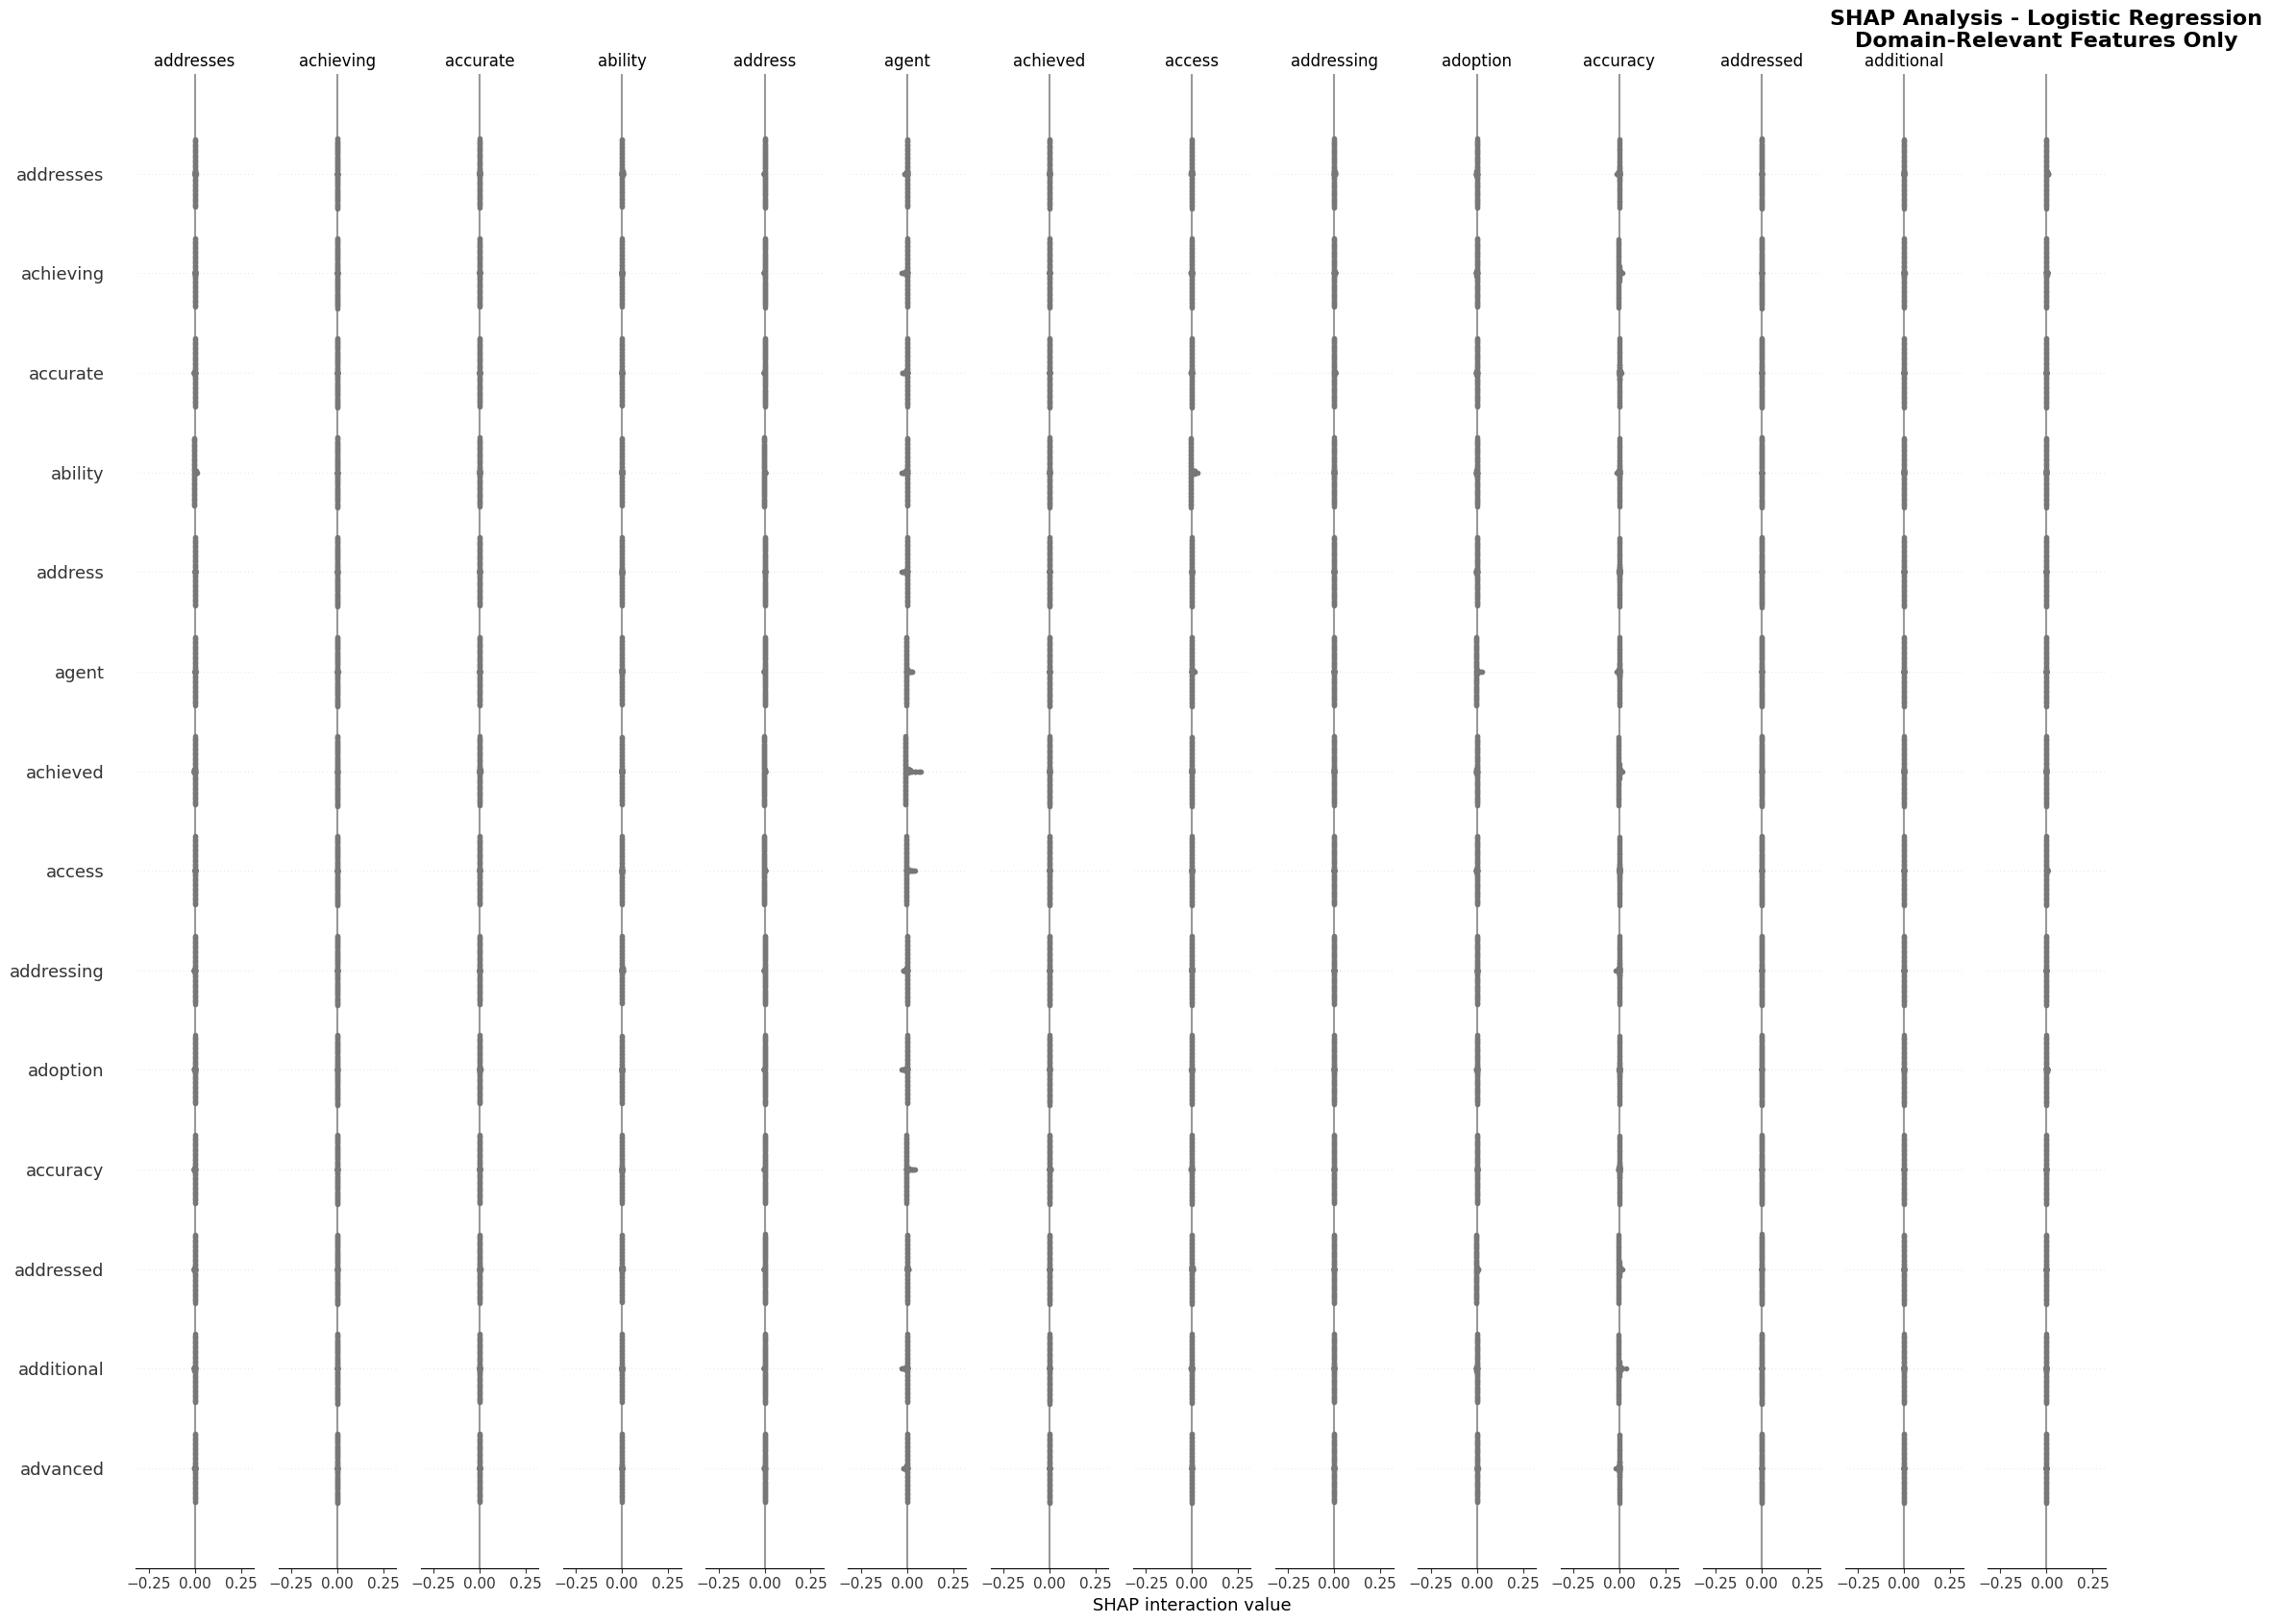


Top 20 domain-relevant features:
 1. achieved                            | Importance:  0.0005 | General
 2. ability                             | Importance:  0.0004 | General
 3. agent                               | Importance:  0.0004 | General
 4. addresses                           | Importance:  0.0003 | General
 5. accurate                            | Importance:  0.0003 | General
 6. additional                          | Importance:  0.0003 | General
 7. achieving                           | Importance:  0.0003 | General
 8. addressing                          | Importance:  0.0003 | General
 9. access                              | Importance:  0.0003 | General
10. advanced                            | Importance:  0.0003 | General
11. accuracy                            | Importance:  0.0003 | General
12. address                             | Importance:  0.0003 | General
13. adoption                            | Importance:  0.0003 | General
14. addressed                 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.feature_extraction import text
import warnings

warnings.filterwarnings('ignore')

def run_complete_shap_analysis_fixed():
    """
    Run complete SHAP analysis with fixed handling of SHAP array structure and domain-relevant features.
    Loads the best performing model from a batch directory, prepares test data,
    filters domain-relevant features, and generates SHAP summary plots.

    Returns:
        tuple: (domain_relevant_features, shap_values_filtered) or (None, None) on failure
    """
    batch_path = f"{best_iteration_measure}"
    test_data_path = f"{best_iteration_measure}/data/test_data.csv"

    print("Starting complete SHAP analysis")

    def load_best_model_and_vectorizer(batch_path):
        """Find and load the best model based on validation accuracy."""
        models_dir = os.path.join(batch_path, "models")
        best_model = None
        best_accuracy = -1
        vectorizer = None

        for model_name in os.listdir(models_dir):
            model_dir = os.path.join(models_dir, model_name)
            if os.path.isdir(model_dir):
                for model_file in os.listdir(model_dir):
                    if model_file.startswith("chunk_") and model_file.endswith(".pkl"):
                        try:
                            with open(os.path.join(model_dir, model_file), 'rb') as f:
                                model_data = pickle.load(f)
                            accuracy = model_data['metrics']['accuracy']
                            if accuracy > best_accuracy:
                                best_accuracy = accuracy
                                best_model = {
                                    'model_name': model_name,
                                    'chunk_id': int(model_file.split('_')[1].split('.')[0]),
                                    'model': model_data['model'],
                                    'accuracy': accuracy,
                                    'vectorizer': model_data['vectorizer']
                                }
                                vectorizer = model_data['vectorizer']
                        except Exception:
                            continue
        return best_model, vectorizer

    best_model_info, vectorizer = load_best_model_and_vectorizer(batch_path)

    if best_model_info is None:
        print("Could not load any model from batch path.")
        return None, None

    print(f"Best model found: {best_model_info['model_name']} (chunk {best_model_info['chunk_id']})")
    print(f"Training accuracy: {best_model_info['accuracy']:.4f}")

    try:
        test_df = pd.read_csv(test_data_path)
        print(f"Loaded test data: {test_df.shape}")
    except Exception:
        print(f"Could not load test data from {test_data_path}")
        return None, None

    texts_test = test_df['full_summary'].fillna('').astype(str)
    X_test = vectorizer.transform(texts_test)
    feature_names = vectorizer.get_feature_names_out()

    enhanced_stop_words = text.ENGLISH_STOP_WORDS.union([
        'company', 'industry', 'business', 'service', 'product',
        'technology', 'solution', 'system', 'platform', 'application',
        'based', 'including', 'provide', 'within', 'across', 'using',
        'new', 'also', 'used', 'well', 'may', 'like', 'make', 'take',
        'one', 'would', 'could', 'first', 'time', 'way', 'even', 'much',
        '10', '100', '15', '20', '30', '50', '000', '2023', '2024', '2025',
        'http', 'https', 'www', 'com', 'org', 'net', 'html'
    ])

    domain_relevant_indices = []
    domain_relevant_features = []

    for i, feature in enumerate(feature_names):
        feature_words = feature.lower().split()
        if not any(word in enhanced_stop_words for word in feature_words):
            domain_relevant_indices.append(i)
            domain_relevant_features.append(feature)

    print(f"Analyzed features:")
    print(f" Total features: {len(feature_names)}")
    print(f" Domain-relevant features: {len(domain_relevant_features)}")

    print("Sample domain-relevant features:")
    for i, feature in enumerate(domain_relevant_features[:20]):
        print(f" {i+1:2d}. {feature}")

    import shap
    best_model = best_model_info['model']

    if X_test.shape[0] > 100:
        X_sample = X_test[:100]
    else:
        X_sample = X_test

    try:
        if hasattr(best_model, 'predict_proba'):
            if hasattr(best_model, 'feature_importances_'):
                explainer = shap.TreeExplainer(best_model)
                shap_values = explainer.shap_values(X_sample)
            else:
                explainer = shap.LinearExplainer(best_model, X_sample)
                shap_values = explainer.shap_values(X_sample)

            if isinstance(shap_values, list):
                shap_values_single = shap_values[0]  # For multi-class
            else:
                shap_values_single = shap_values  # Binary

            if hasattr(shap_values_single, 'shape') and len(shap_values_single.shape) > 1:
                shap_values_filtered = shap_values_single[:, domain_relevant_indices]
            else:
                shap_values_filtered = shap_values_single[domain_relevant_indices]

            plt.figure(figsize=(14, 8))
            shap.summary_plot(
                shap_values_filtered,
                X_sample[:, domain_relevant_indices],
                feature_names=domain_relevant_features,
                show=False,
                max_display=20
            )
            plt.title(f"SHAP Analysis - {best_model_info['model_name'].replace('_', ' ').title()}\nDomain-Relevant Features Only",
                      fontsize=16, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.savefig('shap_analysis_domain_relevant.png', dpi=300, bbox_inches='tight')
            plt.show()

            display_top_domain_features_fixed(domain_relevant_features, shap_values_filtered)

            print("SHAP analysis completed successfully.")

            return domain_relevant_features, shap_values_filtered
        else:
            print("SHAP is not supported for this model type.")
            return None, None
    except Exception as e:
        import traceback
        print(f"SHAP analysis failed: {e}\n{traceback.format_exc()}")
        return None, None

def display_top_domain_features_fixed(feature_names, shap_values, top_n=20):
    """
    Display the most important domain-relevant features based on SHAP values.

    Args:
        feature_names (list): List of domain-relevant feature names.
        shap_values (array): SHAP values corresponding to features.
        top_n (int): Number of top features to display.
    """
    shap_array = np.array(shap_values)
    if len(shap_array.shape) > 1 and shap_array.shape[0] > 1:
        shap_array = shap_array[0]

    if len(shap_array.shape) > 1:
        feature_importance = np.abs(shap_array).mean(axis=0)
    else:
        feature_importance = np.abs(shap_array)

    top_indices = np.argsort(feature_importance)[-top_n:][::-1]

    print(f"\nTop {min(top_n, len(feature_names))} domain-relevant features:")
    print("=" * 60)

    domain_categories = {
        'TECH': ['software', 'tech', 'digital', 'cloud', 'ai', 'data', 'algorithm', 'machine', 'learning'],
        'FINANCE': ['financial', 'bank', 'investment', 'wealth', 'portfolio', 'asset', 'capital', 'risk'],
        'HEALTHCARE': ['medical', 'health', 'patient', 'care', 'clinical', 'hospital', 'treatment'],
        'BUSINESS': ['management', 'strategy', 'consulting', 'business', 'enterprise', 'market'],
        'OPERATIONS': ['operation', 'process', 'efficiency', 'workflow', 'automation', 'logistics'],
        'ANALYTICS': ['analytics', 'analysis', 'insight', 'metric', 'reporting', 'intelligence']
    }

    for i, idx in enumerate(top_indices):
        if i < len(feature_names) and i < top_n:
            feature = feature_names[idx]
            importance = feature_importance[idx]

            category = "General"
            for domain, keywords in domain_categories.items():
                if any(keyword in feature.lower() for keyword in keywords):
                    category = domain
                    break

            print(f"{i+1:2d}. {feature:35} | Importance: {importance:7.4f} | {category}")
from PIL import Image
import IPython.display as display
import os

def display_saved_shap_plot():
    """
    Display the saved SHAP plot image in a Jupyter Notebook environment.
    """
    image_path = "shap_analysis_domain_relevant.png"
    if os.path.exists(image_path):
        try:
            print(f"Displaying SHAP plot: {image_path}")
            img = Image.open(image_path)
            display.display(img)
        except Exception as e:
            print(f"Error displaying image: {e}")
    else:
        print(f"SHAP plot not found at {image_path}. Please generate the plot first.")

print("Starting complete SHAP analysis...")
features, values = run_complete_shap_analysis_fixed()

if features is not None:
    print(f"ANALYSIS COMPLETE!")
    print(f"SHAP plot has been generated and saved")

    # Display the saved plot
    #display_saved_shap_plot()
else:
    print(f"\nTROUBLESHOOTING:")
    print(f"   1. Make sure {best_iteration_measure} exists")
    print(f"   2. Check that models are saved in the batch directory")
    print(f"   3. Ensure SHAP is installed: pip install shap")


